# Data Cleaning, Harmonization, and Exploratory Data Analysis

## Setup

### Import libraries

In [1]:
# standard library
from concurrent import futures
import logging
import multiprocessing as mp
from pathlib import Path
from typing import Callable, Optional, Sequence, Tuple, Iterable, List

# third-party libraries
import colorcet as cc
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import SaltRemover, Descriptors, rdMolDescriptors
from scipy import stats
from tqdm.auto import tqdm

In [2]:
# setup tqdm
tqdm.pandas()

In [3]:
# setup logging
level = logging.DEBUG
logger = logging.getLogger(__name__)
if logger.hasHandlers():
    logger.handlers.clear()

formatter = logging.Formatter(
    "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)
ch = logging.StreamHandler()
ch.setFormatter(formatter)
logger.addHandler(ch)
logger.setLevel(level)

logger.info("Imports successful.")


2025-10-26 17:41:38,310 - __main__ - INFO - Imports successful.


### Local libraries

In [4]:
# Defensive canonicalization helper and robust parallel runner
from typing import Iterable, List, Optional

def canonicalize_smiles(smiles: str, isomeric: bool = True) -> Optional[str]:
    """Convert SMILES string to its canonical form with defensive checks.

    Returns None for invalid inputs or on failures.
    """
    # handle missing/NaN inputs
    if smiles is None:
        return None
    try:
        s = str(smiles)
    except Exception:
        logger.warning(f"Unable to convert SMILES to string: {smiles}")
        return None

    # parse molecule
    mol = Chem.MolFromSmiles(s)
    if mol is None:
        logger.debug(f"Invalid SMILES string could not be parsed: {s}")
        return None

    # remove salts safely
    try:
        remover = SaltRemover.SaltRemover()
        mol = remover.StripMol(mol, dontRemoveEverything=True)
    except Exception:
        logger.exception(f"Salt removal failed for SMILES: {s}")
        return None

    if mol.GetNumAtoms() == 0:
        logger.debug(f"Molecule empty after salt removal: {s}")
        return None

    # return canonical SMILES (catch failures)
    try:
        smi = Chem.MolToSmiles(mol, canonical=True, isomericSmiles=isomeric, doRandom=False)
        return smi
    except Exception:
        logger.exception(f"MolToSmiles failed for molecule from SMILES: {s}")
        return None

def parallel_canonicalize_smiles(smiles_list: Iterable, isomeric: bool = True, max_workers: int = None) -> List[Optional[str]]:
    """
    Parallel canonicalization that submits all tasks first and then retrieves results.

    - Submits all jobs with executor.submit() to ensure all computations are started.
    - Uses futures.as_completed to retrieve results as they finish, but stores each
      result at its original index so output order matches input order.
    - Handles per-task exceptions and logs them, returning None for failed items.
    """
    if smiles_list is None:
        return []

    # coerce to list to allow indexing and deterministic ordering
    smiles_seq = list(smiles_list)
    n = len(smiles_seq)
    if n == 0:
        return []

    if max_workers is None:
        max_workers = min(32, (mp.cpu_count() or 1) + 4)

    logger.debug(f"Using {max_workers} workers for parallel SMILES canonicalization. Total tasks: {n}")

    results: List[Optional[str]] = [None] * n
    future_to_index = {}
    with futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        # submit all tasks first
        for idx, smi in enumerate(smiles_seq):
            future = executor.submit(canonicalize_smiles, smi, isomeric)
            future_to_index[future] = idx

        # collect results as they complete, but place them at the original index
        for completed in tqdm(futures.as_completed(future_to_index), total=n, desc="Canonicalizing SMILES"):
            idx = future_to_index[completed]
            try:
                res = completed.result()
            except Exception:
                logger.exception(f"Canonicalization task failed for index {idx} (SMILES: {smiles_seq[idx]})")
                res = None
            results[idx] = res

    return results


In [5]:
def calc_stats(series: Series) -> str:
    """
    Calculate summary statistics for a pandas Series and format as a string.

    Parameters
    ----------
    series : pandas.Series
        Numeric column to summarize.

    Returns
    -------
    str
        Formatted string with min, max, mean, median, std, skew, kurtosis, and count.
    """
    array = series.dropna().to_numpy()

    # calc min, max, median, mean, std, skew, kurtosis, count
    out = {
        "min": np.min(array),
        "max": np.max(array),
        "mean": np.mean(array),
        "median": np.median(array),
        "std": np.std(array, ddof=1) if len(array) > 1 else np.nan,
        "skew": stats.skew(array) if len(array) > 2 else np.nan,
        "kurtosis": stats.kurtosis(array) if len(array) > 3 else np.nan,
        "count": len(array),
    }
    stats_str = (
        f"min: {out['min']:.4g}\n"
        f"max: {out['max']:.4g}\n"
        f"mean: {out['mean']:.4g}\n"
        f"median: {out['median']:.4g}\n"
        f"std: {out['std']:.4g}\n"
        f"skew: {out['skew']:.4g}\n"
        f"kurtosis: {out['kurtosis']:.4g}\n"
        f"count: {out['count']}"
    )
    return stats_str

def plot_numeric_distributions(
    df: DataFrame,
    columns: Optional[Sequence[str]] = None,
    n_cols: int = 3,
    figsize_per_cell: Tuple[int, int] = (6, 4),
    stat_func: Callable[[Series], str] = calc_stats,
    kde: bool = True,
    title: Optional[str] = None,
    save_path: Optional[Path] = None,
) -> Tuple[plt.Figure, np.ndarray]:
    """
    Plot histograms (with optional KDE) for numeric columns in a dataframe
    arranged in a grid, adding summary statistics text on each subplot.

    Parameters
    ----------
    df : pandas.DataFrame
        Input dataframe.
    columns : Sequence[str], optional
        Sequence of column names to plot. If None, all numeric columns are used.
    n_cols : int
        Number of columns in the grid.
    figsize_per_cell : tuple (width, height)
        Size multiplier for each grid cell.
    stat_func : callable
        Function that accepts a pandas.Series and returns a formatted string
        with statistics (used to render the textbox). Default: calc_stats.
    kde : bool
        Whether to draw KDE on top of histograms.
    title : str, optional
        Optional overall title for the figure.
    save_path : pathlib.Path, optional
        If provided, saves the figure to this path.

    Returns
    -------
    fig : matplotlib.figure.Figure
        The created figure.
    axes : numpy.ndarray
        Flattened array of Axes objects (unused axes will be turned off).
    """
    if columns is None:
        columns = df.select_dtypes(include=["number"]).columns.tolist()

    n_features = len(columns)
    if n_features == 0:
        raise ValueError("No numeric columns to plot.")

    n_rows = int(np.ceil(n_features / float(n_cols)))
    fig_w = figsize_per_cell[0] * n_cols
    fig_h = figsize_per_cell[1] * n_rows

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_w, fig_h))
    axes = np.atleast_1d(np.array(axes).flatten())

    for i, col in enumerate(columns):
        ax = axes[i]
        series = df[col].dropna()
        sns.histplot(series, kde=kde, ax=ax)
        try:
            stat_text = stat_func(series)
        except Exception:
            stat_text = ""
        ax.set_xlabel(col, fontsize=12)
        ax.set_ylabel("Count", fontsize=12)
        ax.grid(True, linestyle=":", alpha=0.7)
        ax.tick_params(axis="x", labelrotation=30, labelsize=10)
        ax.tick_params(axis="y", labelsize=10)
        if stat_text:
            ax.text(
                0.95,
                0.95,
                stat_text,
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment="top",
                horizontalalignment="right",
                bbox=dict(facecolor="white", alpha=0.75, edgecolor="black"),
            )

    # turn off any unused axes
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    if title:
        fig.suptitle(title, fontsize=16, y=1.01)

    fig.tight_layout()
    if save_path is not None:
        fig.savefig(str(save_path), bbox_inches="tight", dpi=150)

    return fig, axes


def plot_correlation_matrix(
    df: DataFrame,
    columns: Optional[Sequence[str]] = None,
    figsize: Tuple[int, int] = (12, 10),
    cmap: str = "mako",
    annot: bool = True,
    fmt: str = ".2f",
    square: bool = True,
    cbar_label: str = "Correlation",
    linewidths: float = 0.5,
    linecolor: str = "white",
    annot_kws: Optional[dict] = None,
    xtick_rotation: int = 45,
    xtick_ha: str = "right",
    xtick_fontsize: int = 12,
    ytick_rotation: int = 0,
    ytick_fontsize: int = 12,
    title: Optional[str] = "Correlation Matrix of Numeric Columns",
    save_path: Optional[Path] = None,
) -> Tuple[plt.Figure, plt.Axes]:
    """
    Compute and plot a correlation matrix for numeric columns in `df`.

    Returns the (fig, ax).
    """
    if columns is None:
        columns = df.select_dtypes(include=["number"]).columns.tolist()
    if len(columns) == 0:
        raise ValueError("No numeric columns to compute correlation for.")

    corr = df[columns].corr()

    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(
        corr,
        annot=annot,
        cmap=cmap,
        fmt=fmt,
        ax=ax,
        square=square,
        cbar_kws={"label": cbar_label},
        linewidths=linewidths,
        linecolor=linecolor,
        annot_kws=(annot_kws or {"size": 12}),
    )

    if title:
        ax.set_title(title, fontsize=18)
    ax.set_xlabel("Features", fontsize=14)
    ax.set_ylabel("Features", fontsize=14)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=xtick_rotation, ha=xtick_ha, fontsize=xtick_fontsize)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=ytick_rotation, fontsize=ytick_fontsize)
    fig.tight_layout()

    if save_path is not None:
        fig.savefig(str(save_path), bbox_inches="tight", dpi=150)

    return fig, ax


def compute_molecular_properties(smiles: Iterable[str]) -> pd.DataFrame:
    """
    Compute a set of common molecular properties for a series/iterable
    of SMILES strings.

    Parameters
    ----------
    smiles : Iterable[str]
        Iterable of canonical SMILES strings.

    Returns
    -------
    pandas.DataFrame
        DataFrame with columns:
        ['SMILES','MW','TPSA','HBA','HBD','RotBonds','LogP',
         'NumHeavyAtoms','NumRings']
    """
    rows: List[dict] = []
    for smi in pd.Series(smiles).dropna().astype(str).tolist():
        try:
            mol = Chem.MolFromSmiles(smi)
        except Exception:
            mol = None
        if mol is None:
            continue
        rows.append(
            {
                "SMILES": smi,
                "MW": Descriptors.MolWt(mol),
                "TPSA": Descriptors.TPSA(mol),
                "HBA": Descriptors.NumHAcceptors(mol),
                "HBD": Descriptors.NumHDonors(mol),
                "RotBonds": Descriptors.NumRotatableBonds(mol),
                "LogP": Descriptors.MolLogP(mol),
                "NumHeavyAtoms": Descriptors.HeavyAtomCount(mol),
                "NumRings": rdMolDescriptors.CalcNumRings(mol),
            }
        )
    return pd.DataFrame(rows)


def plot_property_distributions(
    props_df: pd.DataFrame,
    columns: List[str] = None,
    n_cols: int = 4,
    figsize_per_cell: tuple = (4, 3),
    bins: int = 30,
    kde: bool = True,
    title: str = "Molecular Property Distributions",
    save_path: str = None,
) -> tuple:
    """
    Plot distributions of molecular properties in a grid.

    Returns (fig, axes).
    """
    if columns is None:
        columns = [
            "MW",
            "TPSA",
            "HBA",
            "HBD",
            "RotBonds",
            "LogP",
            "NumHeavyAtoms",
            "NumRings",
        ]
    cols = [c for c in columns if c in props_df.columns]
    if not cols:
        raise ValueError("No valid property columns found in props_df.")

    n_features = len(cols)
    n_rows = int(np.ceil(n_features / float(n_cols)))
    fig_w = figsize_per_cell[0] * n_cols
    fig_h = figsize_per_cell[1] * n_rows

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_w, fig_h))
    axes = np.atleast_1d(np.array(axes).flatten())

    for i, col in enumerate(cols):
        ax = axes[i]
        series = props_df[col].dropna()
        sns.histplot(series, bins=bins, kde=kde, ax=ax, color="C0")
        stat_text = calc_stats(series)
        ax.set_xlabel(col, fontsize=10)
        ax.set_ylabel("Count", fontsize=10)
        ax.grid(True, linestyle=":", alpha=0.6)
        ax.tick_params(axis="x", labelrotation=30, labelsize=9)
        ax.tick_params(axis="y", labelsize=9)
        if stat_text:
            ax.text(
                0.95,
                0.95,
                stat_text,
                transform=ax.transAxes,
                fontsize=9,
                verticalalignment="top",
                horizontalalignment="right",
                bbox=dict(facecolor="white", alpha=0.75, edgecolor="black"),
            )

    # hide any unused axes
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    if title:
        fig.suptitle(title, fontsize=14, y=1.02)
    fig.tight_layout()
    if save_path:
        fig.savefig(save_path, bbox_inches="tight", dpi=150)
    return fig, axes


In [53]:
cols_with_units = {
    "Molecule Name": "(None)",
    "LogD": "(None)",
    "KSOL": "(uM)",
    "HLM CLint": "(mL/min/kg)",
    "MLM CLint": "(mL/min/kg)",
    "Caco-2 Permeability Papp A>B": "(10^-6 cm/s)",
    "Caco-2 Permeability Efflux": "(None)",
    "MPPB": "(% unbound)",
    "MBPB": "(% unbound)",
    "MGMB": "(% unbound)",
}

transformations = {
    "None": lambda x: x,
    "10^(x+6)": lambda x: 10.0 ** (x + 6.0),
    "10^(x)": lambda x: 10.0 ** (x),
    "10^(x); /mg to /kg": lambda x: (10.0 ** x) / 1.0e-6,
    "ug/mL to uM": lambda x, mw: (x * 1000) / mw if mw > 0 else np.nan,
}

## Load Data

In [7]:
cleaned_data = {}

In [8]:
# project data root directory
base_data_dir = Path().cwd().parents[0] / "assets/dataset/raw"

if not base_data_dir.exists():
    raise FileNotFoundError(f"Data directory not found at {base_data_dir}")

logger.info(f"Data directory found at {base_data_dir}")
for dataset_dir in base_data_dir.iterdir():
    logger.info(f"Dataset name: {dataset_dir.name}")

2025-10-26 17:41:38,749 - __main__ - INFO - Data directory found at /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/raw
2025-10-26 17:41:38,750 - __main__ - INFO - Dataset name: NCATS
2025-10-26 17:41:38,750 - __main__ - INFO - Dataset name: admetica
2025-10-26 17:41:38,750 - __main__ - INFO - Dataset name: Polaris-Antiviral
2025-10-26 17:41:38,750 - __main__ - INFO - Dataset name: TDC
2025-10-26 17:41:38,751 - __main__ - INFO - Dataset name: Polaris-Biogen
2025-10-26 17:41:38,751 - __main__ - INFO - Dataset name: ExpansionRX
2025-10-26 17:41:38,751 - __main__ - INFO - Dataset name: KERMT
2025-10-26 17:41:38,751 - __main__ - INFO - Dataset name: PharmaBench
2025-10-26 17:41:38,751 - __main__ - INFO - Dataset name: ChEMBL


### Challenge Data: ExpansionRX

In [54]:
# load data
data_path = base_data_dir / "ExpansionRX/expansion_teaser.csv"
df_expansionrx_teaser = pd.read_csv(data_path)

# rename cols to have units
df_expansionrx_teaser.rename(
    columns={k: f"{k} {v}" for k, v in cols_with_units.items()},
    inplace=True,
)

# drop rows with invalid SMILES
df_expansionrx_teaser["SMILES"] = parallel_canonicalize_smiles(
    df_expansionrx_teaser["SMILES"].tolist(),
    isomeric=True,
)
n_none_smiles = df_expansionrx_teaser["SMILES"].isnull().sum()
if n_none_smiles > 0:
    logger.warning(f"Dropping {n_none_smiles} rows with invalid SMILES")
    df_expansionrx_teaser.dropna(subset=["SMILES"], inplace=True)
    df_expansionrx_teaser.reset_index(drop=True, inplace=True)

logger.info(f"Dataframe shape: {df_expansionrx_teaser.shape}")
logger.info(f"Dataframe columns: {df_expansionrx_teaser.columns.tolist()}")

2025-10-26 18:05:11,400 - __main__ - DEBUG - Using 28 workers for parallel SMILES canonicalization. Total tasks: 532


Canonicalizing SMILES:   0%|          | 0/532 [00:00<?, ?it/s]

2025-10-26 18:05:11,691 - __main__ - INFO - Dataframe shape: (532, 11)
2025-10-26 18:05:11,691 - __main__ - INFO - Dataframe columns: ['Molecule Name (None)', 'SMILES', 'LogD (None)', 'KSOL (uM)', 'HLM CLint (mL/min/kg)', 'MLM CLint (mL/min/kg)', 'Caco-2 Permeability Papp A>B (10^-6 cm/s)', 'Caco-2 Permeability Efflux (None)', 'MPPB (% unbound)', 'MBPB (% unbound)', 'MGMB (% unbound)']


In [58]:
df_expansionrx_teaser

,Molecule Name (None),SMILES,LogD (None),KSOL (uM),HLM CLint (mL/min/kg),MLM CLint (mL/min/kg),Caco-2 Permeability Papp A>B (10^-6 cm/s),Caco-2 Permeability Efflux (None),MPPB (% unbound),MBPB (% unbound),MGMB (% unbound)
0,E-0001321,CN1CCC[C@H]1COc1ccc(-c2nc3cc(-c4ccc5[nH]c(-c6c...,NaN,NaN,56.4,182.3,NaN,NaN,NaN,NaN,NaN
1,E-0001780,COc1ccc2c(c1)c1cc3cnccc3c(C)c1n2C,NaN,NaN,160.4,1351.1,NaN,NaN,NaN,NaN,NaN
2,E-0001827,Cc1c2ccncc2cc2c3cc(OCCCN4CCN(C)CC4)ccc3n(C)c12,NaN,NaN,NaN,193.5,NaN,NaN,NaN,NaN,NaN
3,E-0002019,CN(C)CCCOc1ccc(-c2nc3cc(NC(=O)c4ccc5[nH]c(-c6c...,NaN,NaN,9.5,NaN,NaN,NaN,NaN,NaN,NaN
4,E-0002036,CN(C)CCCOc1ccc2nc(-c3ccc(-c4nc5ccc(OCCCN(C)C)c...,NaN,NaN,NaN,162.0,NaN,NaN,NaN,NaN,0.0122
...,...,...,...,...,...,...,...,...,...,...,...
527,E-0012796,Nc1cc2c(cc1-n1cc(OCCN3CCCCC3)cn1)NC(=O)CC2,0.5,67.80,1.5,48.7,8.94,2.30,NaN,NaN,NaN
528,E-0012797,Fc1cccc(-c2ccnc(Nc3ccc(CN4CCOCC4)cc3)c2)c1,NaN,7.62,41.3,4524.6,5.04,0.56,NaN,NaN,NaN
529,E-0012798,Fc1cccc(-c2cncc(Nc3ccc(CN4CCOCC4)cc3)n2)c1,4.4,1.60,120.8,2258.3,5.68,1.02,NaN,NaN,NaN
530,E-0012799,Fc1cccc(-c2nccc(Nc3ccc(CN4CCOCC4)cc3)n2)c1,3.7,28.40,98.4,3326.7,9.51,0.82,NaN,NaN,NaN


In [55]:
cleaned_data["expansionrx_teaser"] = df_expansionrx_teaser.copy()

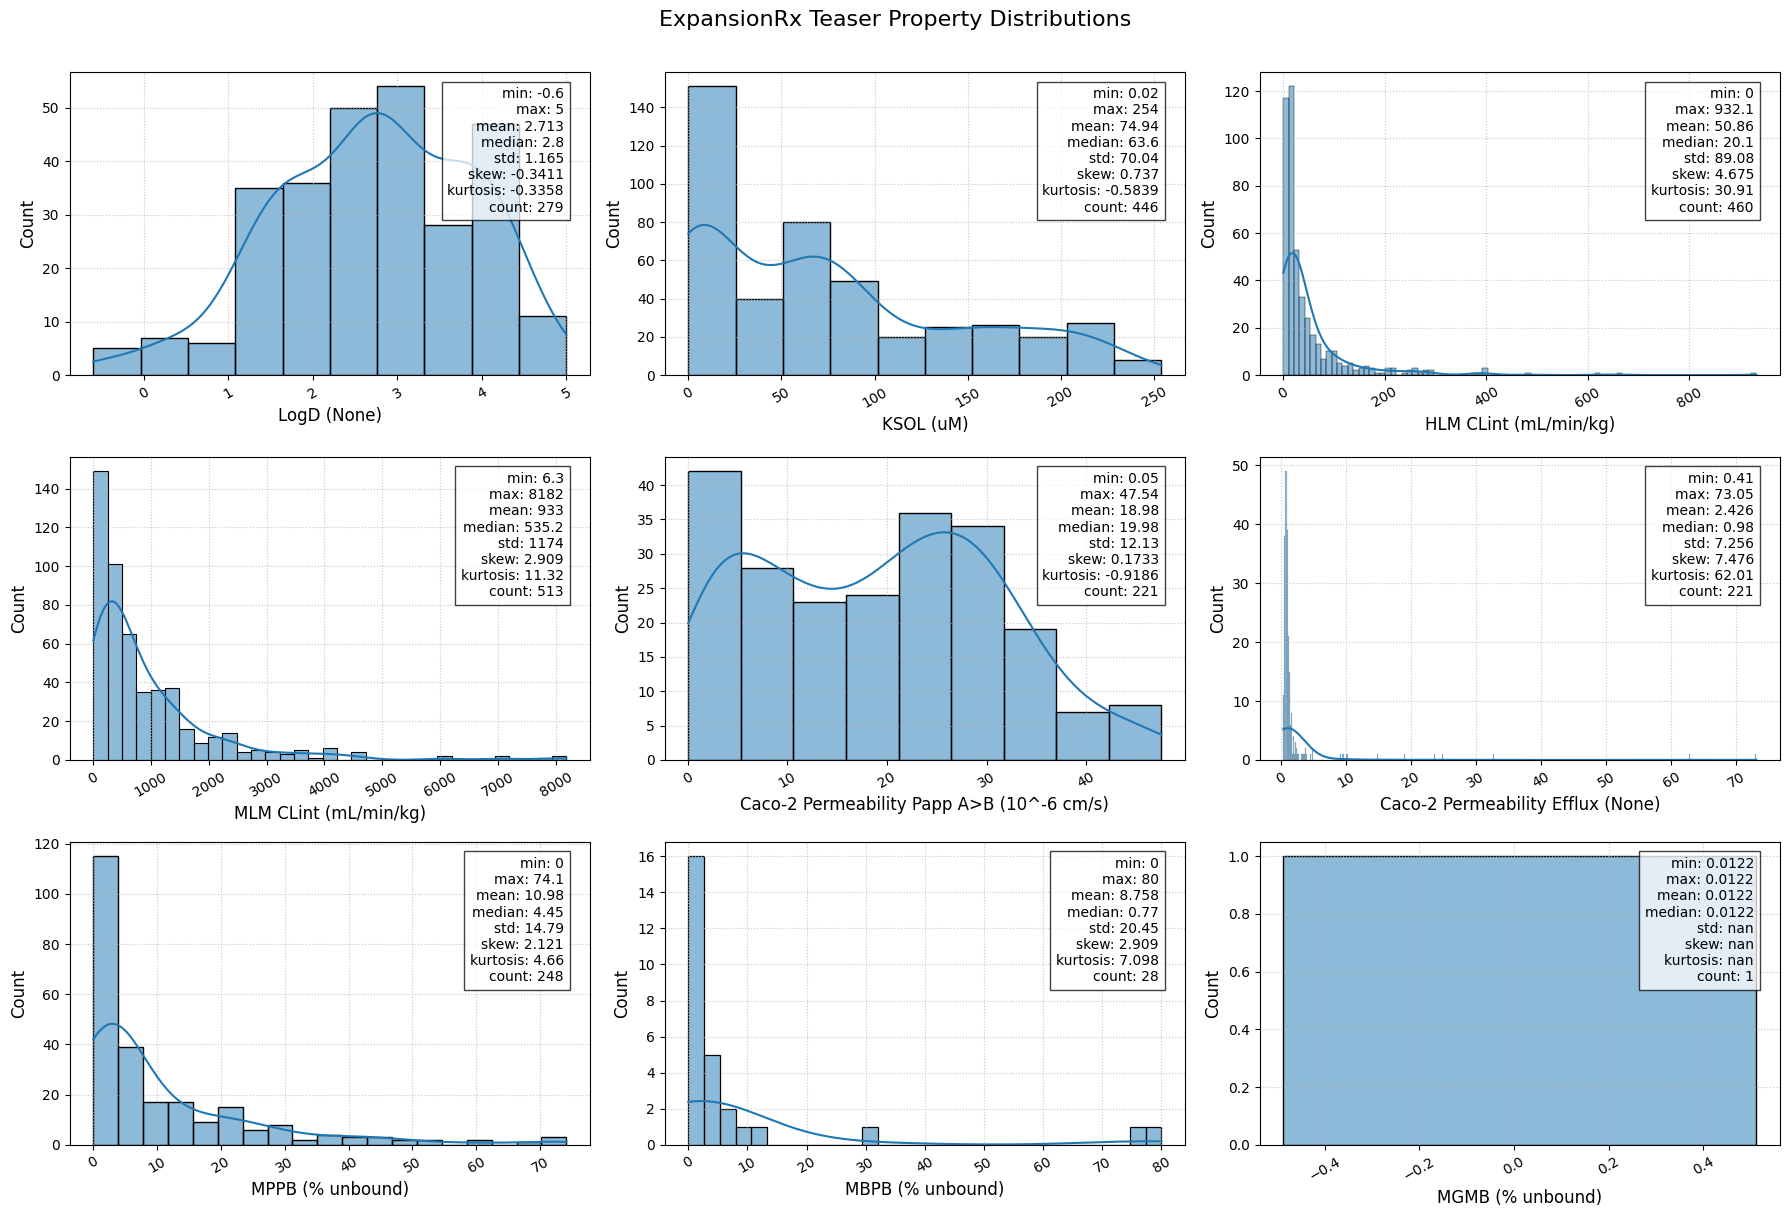

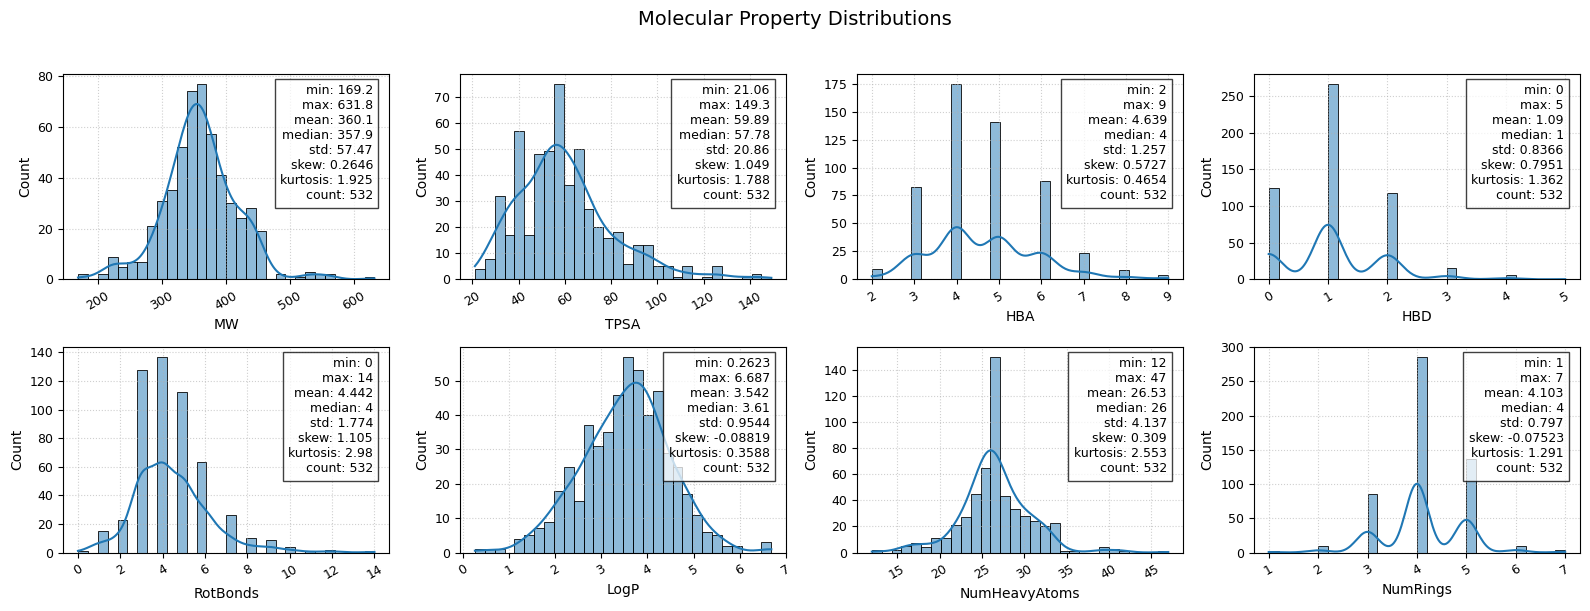

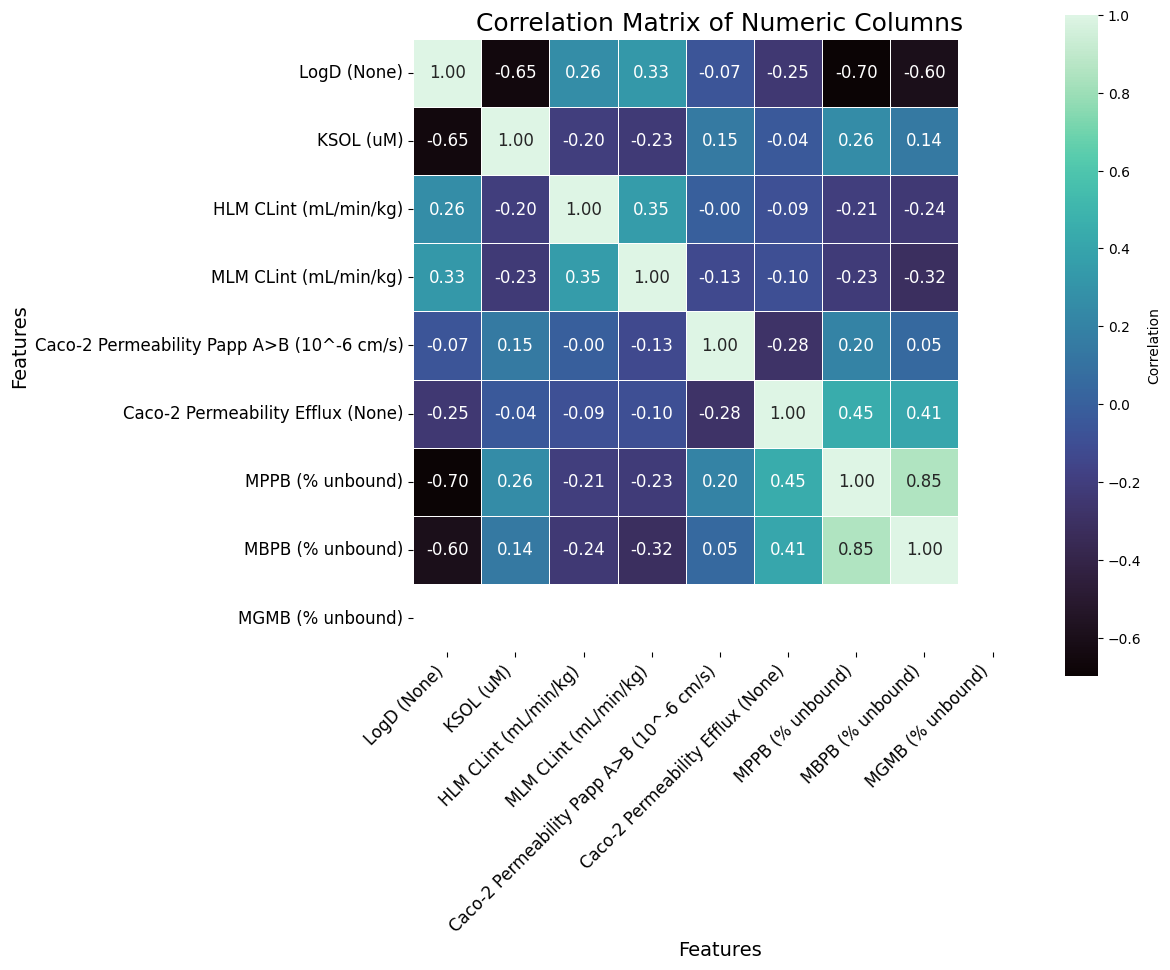

In [56]:
df = df_expansionrx_teaser.copy()
output_dir = data_path.parents[1] / "figures"
fname = "expansionrx_teaser"

df_props = compute_molecular_properties(df["SMILES"])
output_dir.mkdir(parents=True, exist_ok=True)
fig, ax = plot_numeric_distributions(
    df,
    n_cols=3,
    title="ExpansionRx Teaser Property Distributions",
    save_path=output_dir / f"{fname}_numeric_distributions.png",
)
fig, ax = plot_property_distributions(
    df_props,
    save_path=output_dir / f"{fname}_molecular_property_distributions.png",
)
fig, ax = plot_correlation_matrix(
    df,
    save_path=output_dir / f"{fname}_numeric_correlation_matrix.png",
)

### KERMT Dataset

#### Public

Key dataset information

In [12]:
files_biogen = [
    "KERMT/export_public_cluster_split/all_test_cluster_morgan.csv",
    "KERMT/export_public_cluster_split/all_train_fold_0_cluster_morgan.csv",
    "KERMT/export_public_cluster_split/all_val_fold_0_cluster_morgan.csv",
]

# map from KERMT data to ExpansionRX data on SMILES
map_cols_kermt_to_expansionrx = [
    {
        "input_col": "LogD_pH_7.4",
        "output_col": "LogD (None)",
        "transform": transformations["None"],
    },
    {
        "input_col": "kinetic_logSaq",  # log(M)
        "output_col": "KSOL (uM)",
        "transform": transformations["10^(x+6)"],
    },
    {
        "input_col": "CL_microsome_human",  # log(mL/min/kg)
        "output_col": "HLM CLint (mL/min/kg)",
        "transform": transformations["10^(x)"],
    },
    {
        "input_col": "CL_microsome_mouse",  # log(mL/min/kg)
        "output_col": "MLM CLint (mL/min/kg)",
        "transform": transformations["10^(x)"],
    },
    {
        "input_col": "Papp_Caco2",  # log(10^-6 cm/sec)
        "output_col": "Caco-2 Permeability Papp A>B (10^-6 cm/s)",
        "transform": transformations["10^(x)"],
    },
    {
        # REVIEW: low confidence mapping
        "input_col": "Pgp_human",  # log(None)
        "output_col": "Caco-2 Permeability Efflux (None)",
        "transform": transformations["10^(x)"],
    },
]

Load and concatenate public KERMT files. Drop duplicates and bad data.

In [13]:
df_kermt_public = pd.DataFrame()
for f in files_biogen:
    df = pd.read_csv(base_data_dir / f)
    df["file"] = f
    df_kermt_public = pd.concat([df_kermt_public, df], ignore_index=True)

# rename smiles --> SMILES
df_kermt_public.rename(columns={"smiles": "SMILES"}, inplace=True)

# drop rows with invalid SMILES
df_kermt_public["SMILES"] = parallel_canonicalize_smiles(
    df_kermt_public["SMILES"].tolist(),
    isomeric=True,
)
n_none_smiles = df_kermt_public["SMILES"].isnull().sum()
if n_none_smiles > 0:
    logger.warning(f"Dropping {n_none_smiles} rows with invalid SMILES")
    df_kermt_public.dropna(subset=["SMILES"], inplace=True)
    df_kermt_public.reset_index(drop=True, inplace=True)

logger.info(f"KERMT Public Dataframe shape: {df_kermt_public.shape}")
logger.info(f"KERMT Public Dataframe columns: {df_kermt_public.columns.tolist()}")

# print finite number of entries for each column
for col in df_kermt_public.columns:
    if not pd.api.types.is_numeric_dtype(df_kermt_public[col]):
        continue
    n_finite = np.isfinite(df_kermt_public[col]).sum()
    logger.info(f"Column '{col}' has {n_finite} finite entries out of {len(df_kermt_public)}")

2025-10-26 17:41:44,376 - __main__ - DEBUG - Using 28 workers for parallel SMILES canonicalization. Total tasks: 114112


Canonicalizing SMILES:   0%|          | 0/114112 [00:00<?, ?it/s]

2025-10-26 17:42:43,772 - __main__ - INFO - KERMT Public Dataframe shape: (114112, 27)
2025-10-26 17:42:43,772 - __main__ - INFO - KERMT Public Dataframe columns: ['SMILES', 'CL_microsome_human', 'CL_microsome_mouse', 'CL_microsome_rat', 'CL_total_dog', 'CL_total_human', 'CL_total_monkey', 'CL_total_rat', 'CYP2C8_inhibition', 'CYP2C9_inhibition', 'CYP2D6_inhibition', 'CYP3A4_inhibition', 'Dog_fraction_unbound_plasma', 'Human_fraction_unbound_plasma', 'Monkey_fraction_unbound_plasma', 'Rat_fraction_unbound_plasma', 'Papp_Caco2', 'Pgp_human', 'hERG_binding', 'LogD_pH_7.4', 'kinetic_logSaq', 'thermo_logSaq', 'VDss_dog', 'VDss_human', 'VDss_monkey', 'VDss_rat', 'file']
2025-10-26 17:42:43,773 - __main__ - INFO - Column 'CL_microsome_human' has 5218 finite entries out of 114112
2025-10-26 17:42:43,774 - __main__ - INFO - Column 'CL_microsome_mouse' has 663 finite entries out of 114112
2025-10-26 17:42:43,774 - __main__ - INFO - Column 'CL_microsome_rat' has 1798 finite entries out of 114112

Transform dataset column names to be compatible with ExpansionRX dataset.

In [14]:
df_kermt_public_admet_cleaned = df_kermt_public[["SMILES"]]
for mapping in map_cols_kermt_to_expansionrx:
    input_col = mapping["input_col"]
    output_col = mapping["output_col"]
    transform = mapping["transform"]

    df_input = df_kermt_public[["SMILES", input_col]].copy()
    df_input[output_col] = df_input[input_col].apply(transform).copy()
    df_input.drop(columns=[input_col], inplace=True)

    df_kermt_public_admet_cleaned = pd.merge(df_kermt_public_admet_cleaned, df_input, on="SMILES")

Curate dataset to include relevant dynamic ranges for main dataset

In [15]:
# limit KSol to < 250
idx_infinite_ksol = df_kermt_public_admet_cleaned["KSOL (uM)"].isnull()
idx_too_large = df_kermt_public_admet_cleaned["KSOL (uM)"] > 250.0
idx_remove = ~idx_infinite_ksol & idx_too_large
df_kermt_public_admet_cleaned = df_kermt_public_admet_cleaned[~idx_remove].reset_index(drop=True)

# limit Caco-2 Permeability Papp A>B to < 100
idx_infinite_caco2 = df_kermt_public_admet_cleaned["Caco-2 Permeability Papp A>B (10^-6 cm/s)"].isnull()
idx_too_large_caco2 = df_kermt_public_admet_cleaned["Caco-2 Permeability Papp A>B (10^-6 cm/s)"] > 100.0
idx_remove_caco2 = ~idx_infinite_caco2 & idx_too_large_caco2
df_kermt_public_admet_cleaned = df_kermt_public_admet_cleaned[~idx_remove_caco2].reset_index(drop=True)

# limit Caco-2 Permeability Efflux to < 100
idx_infinite_efflux = df_kermt_public_admet_cleaned["Caco-2 Permeability Efflux (None)"].isnull()
idx_too_large_efflux = df_kermt_public_admet_cleaned["Caco-2 Permeability Efflux (None)"] > 100.0
idx_remove_efflux = ~idx_infinite_efflux & idx_too_large_efflux
df_kermt_public_admet_cleaned = df_kermt_public_admet_cleaned[~idx_remove_efflux].reset_index(drop=True)

# drop rows with all NaN values across ADMET columns
admet_cols = [mapping["output_col"] for mapping in map_cols_kermt_to_expansionrx]
df_kermt_public_admet_cleaned.dropna(subset=admet_cols, how="all", inplace=True)
df_kermt_public_admet_cleaned.reset_index(drop=True, inplace=True)

logger.info(f"Merged KERMT-ExpansionRX Dataframe shape: {df_kermt_public_admet_cleaned.shape}")
logger.info(f"Merged KERMT-ExpansionRX Dataframe columns: {df_kermt_public_admet_cleaned.columns.tolist()}")

2025-10-26 17:42:44,299 - __main__ - INFO - Merged KERMT-ExpansionRX Dataframe shape: (91556, 7)
2025-10-26 17:42:44,299 - __main__ - INFO - Merged KERMT-ExpansionRX Dataframe columns: ['SMILES', 'LogD (None)', 'KSOL (uM)', 'HLM CLint (mL/min/kg)', 'MLM CLint (mL/min/kg)', 'Caco-2 Permeability Papp A>B (10^-6 cm/s)', 'Caco-2 Permeability Efflux (None)']


In [16]:
# check for repeated SMILES
n_total = len(df_kermt_public_admet_cleaned)
n_unique = df_kermt_public_admet_cleaned["SMILES"].nunique()
n_duplicates = n_total - n_unique
if n_duplicates > 0:
    logger.warning(f"Found {n_duplicates} duplicate SMILES in merged KERMT-ExpansionRX dataframe")
    # average (skip NaNs) over duplicates
    df_kermt_public_admet_cleaned = df_kermt_public_admet_cleaned.groupby("SMILES", as_index=False).mean()
    logger.info(f"Dataframe shape after averaging duplicates: {df_kermt_public_admet_cleaned.shape}")

# check for overlap with ExpansionRx teaser dataset
smiles_teaser = set(df_expansionrx_teaser["SMILES"].tolist())
smiles_kermt_expansionrx = set(df_kermt_public_admet_cleaned["SMILES"].tolist())
overlap_smiles = smiles_teaser.intersection(smiles_kermt_expansionrx)
n_overlap = len(overlap_smiles)
if n_overlap > 0:
    logger.warning(f"Found {n_overlap} overlapping SMILES between ExpansionRx teaser and KERMT-ExpansionRX datasets")

2025-10-26 17:42:44,366 - __main__ - WARNING - Found 2513 duplicate SMILES in merged KERMT-ExpansionRX dataframe
2025-10-26 17:42:44,428 - __main__ - INFO - Dataframe shape after averaging duplicates: (89043, 7)
2025-10-26 17:42:44,432 - __main__ - WARNING - Found 2 overlapping SMILES between ExpansionRx teaser and KERMT-ExpansionRX datasets


In [17]:
# print num non-nan entries for each column
for col in df_kermt_public_admet_cleaned.columns:
    if col == "SMILES":
        continue
    n_non_nan = df_kermt_public_admet_cleaned[col].notna().sum()
    logger.info(f"Column '{col}' has {n_non_nan} non-NaN entries out of {len(df_kermt_public_admet_cleaned)}")

2025-10-26 17:42:44,474 - __main__ - INFO - Column 'LogD (None)' has 3930 non-NaN entries out of 89043
2025-10-26 17:42:44,474 - __main__ - INFO - Column 'KSOL (uM)' has 74371 non-NaN entries out of 89043
2025-10-26 17:42:44,475 - __main__ - INFO - Column 'HLM CLint (mL/min/kg)' has 5138 non-NaN entries out of 89043
2025-10-26 17:42:44,475 - __main__ - INFO - Column 'MLM CLint (mL/min/kg)' has 662 non-NaN entries out of 89043
2025-10-26 17:42:44,475 - __main__ - INFO - Column 'Caco-2 Permeability Papp A>B (10^-6 cm/s)' has 6398 non-NaN entries out of 89043
2025-10-26 17:42:44,476 - __main__ - INFO - Column 'Caco-2 Permeability Efflux (None)' has 2020 non-NaN entries out of 89043


In [18]:
cleaned_data["kermt_public"] = df_kermt_public_admet_cleaned.copy()

Visualize distributions of dataset

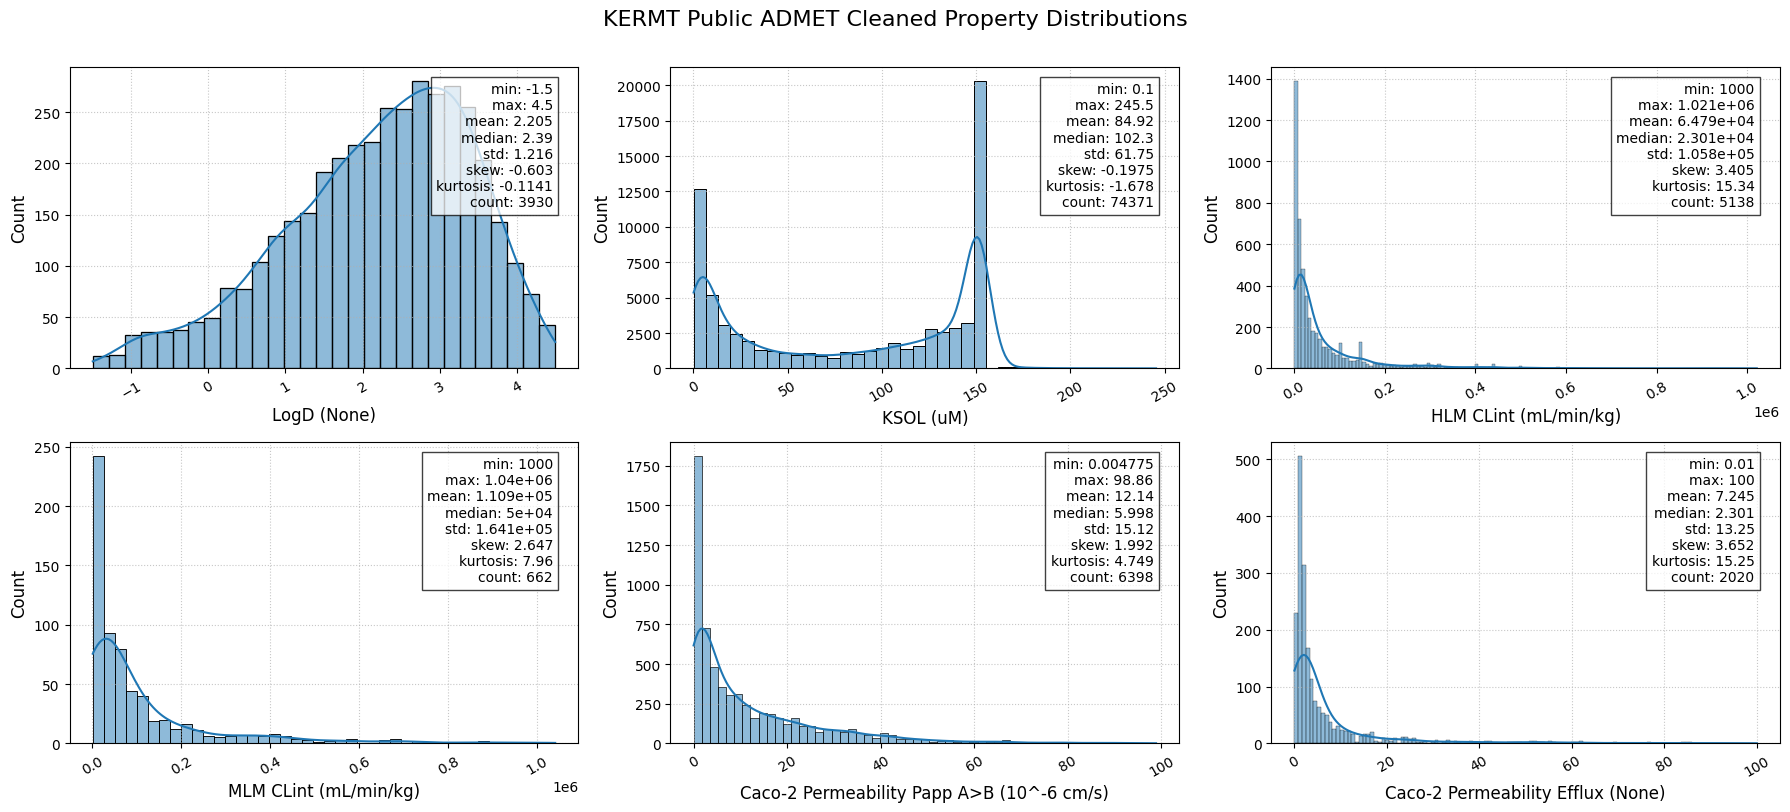

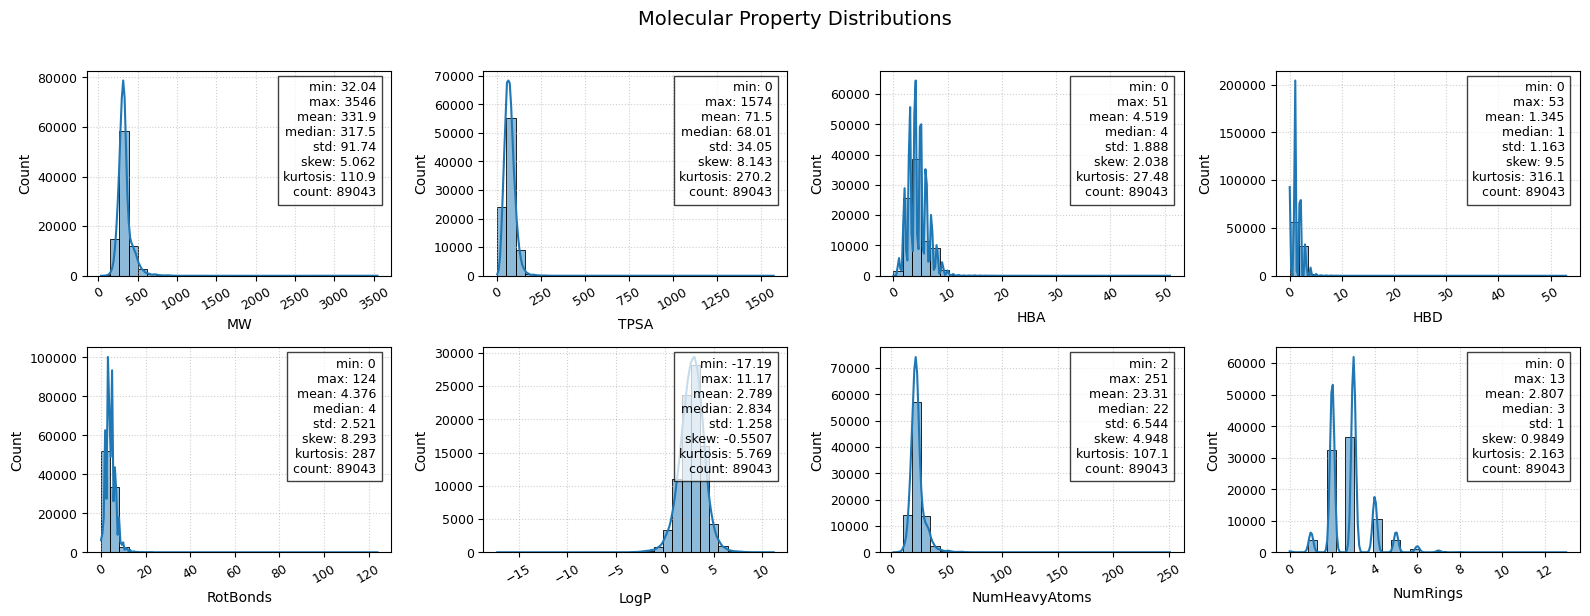

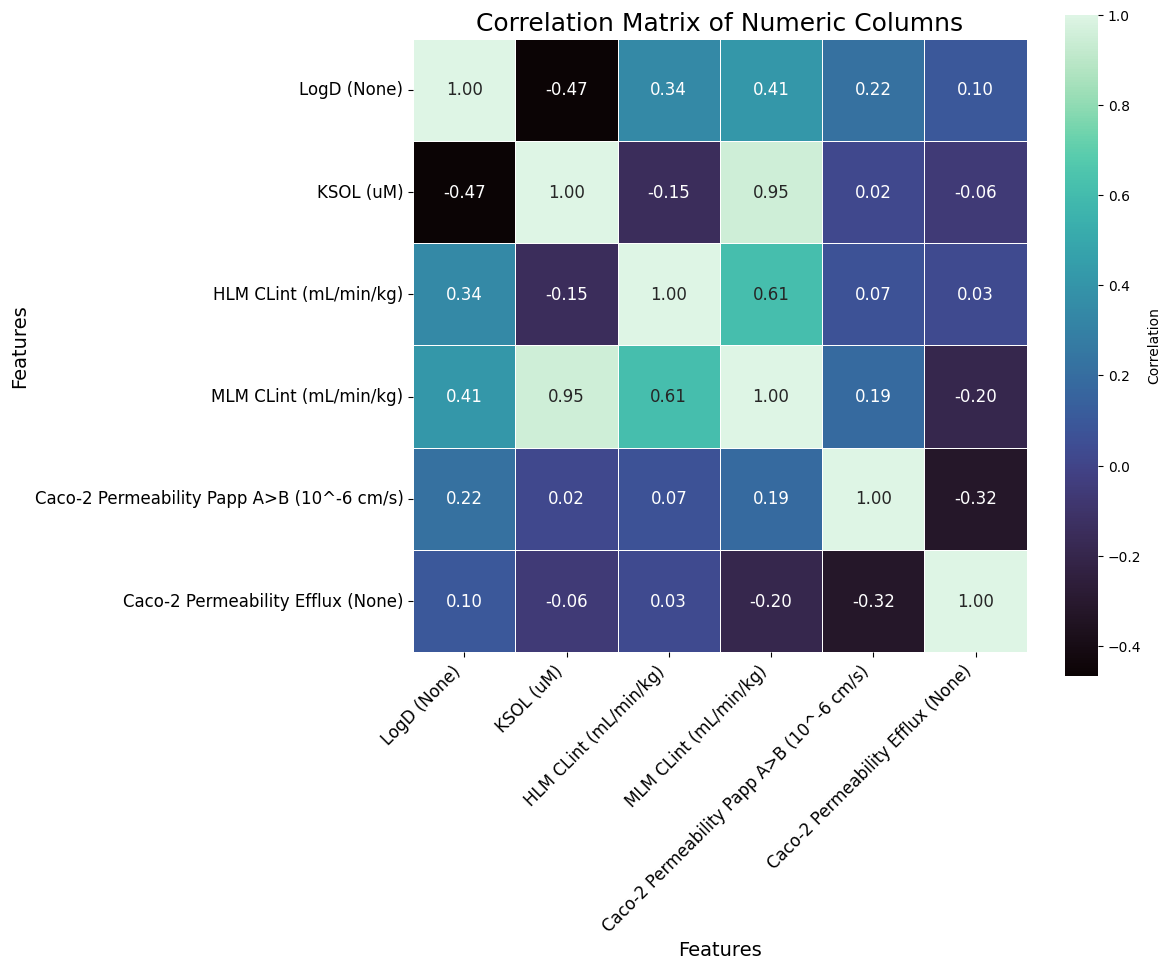

In [20]:
df = df_kermt_public_admet_cleaned.copy()
output_dir = data_path.parents[1] / "figures"
fname = "kermt_public_admet_cleaned"

df_props = compute_molecular_properties(df["SMILES"])
output_dir.mkdir(parents=True, exist_ok=True)
fig, ax = plot_numeric_distributions(
    df,
    n_cols=3,
    title="KERMT Public ADMET Cleaned Property Distributions",
    save_path=output_dir / f"{fname}_numeric_distributions.png",
)
fig, ax = plot_property_distributions(
    df_props,
    save_path=output_dir / f"{fname}_molecular_property_distributions.png",
)
fig, ax = plot_correlation_matrix(
    df,
    save_path=output_dir / f"{fname}_numeric_correlation_matrix.png",
)

#### Biogen

In [21]:
files_biogen = [
    "KERMT/export_biogen_cluster_split/all_test_cluster_morgan.csv",
    "KERMT/export_biogen_cluster_split/all_train_fold_0_cluster_morgan.csv",
    "KERMT/export_biogen_cluster_split/all_val_fold_0_cluster_morgan.csv",
]

map_cols_biogen_to_expansionrx = [
    {
        "input_col": "SOLY_6.8", # FIXME: This is not pH 7
        "output_col": "KSOL (uM)",
        "transform": transformations["ug/mL to uM"],
    },
    {
        "input_col": "MDR1-MDCK_ER", # FIXME: MDCK not Caco-2
        "output_col": "Caco-2 Permeability Efflux (None)",
        "transform": transformations["None"],
    },
    {
        "input_col": "HLM_CLint",
        "output_col": "HLM CLint (mL/min/kg)",
        "transform": transformations["10^(x)"],
    },
]

In [22]:
# load and concatenate biogen files
df_kermt_biogen = [pd.read_csv(base_data_dir / file) for file in files_biogen]
df_kermt_biogen = pd.concat(df_kermt_biogen, ignore_index=True)
logger.info(f"KERMT Biogen Dataframe shape: {df_kermt_biogen.shape}")
logger.info(f"KERMT Biogen Dataframe columns: {df_kermt_biogen.columns.tolist()}")

# rename smiles --> SMILES
df_kermt_biogen.rename(columns={"smiles": "SMILES"}, inplace=True)

# drop rows with invalid SMILES
df_kermt_biogen["SMILES"] = parallel_canonicalize_smiles(
    df_kermt_biogen["SMILES"].tolist(),
    isomeric=True,
)
df_kermt_biogen["MW"] = df_kermt_biogen["SMILES"].apply(lambda smi: Descriptors.MolWt(Chem.MolFromSmiles(smi)) if smi is not None else np.nan)

n_none_smiles = df_kermt_biogen["SMILES"].isnull().sum()
if n_none_smiles > 0:
    logger.warning(f"Dropping {n_none_smiles} rows with invalid SMILES")
    df_kermt_biogen.dropna(subset=["SMILES"], inplace=True)
    df_kermt_biogen.reset_index(drop=True, inplace=True)
logger.info(f"KERMT Biogen Dataframe shape after cleaning: {df_kermt_biogen.shape}")


2025-10-26 17:45:21,542 - __main__ - INFO - KERMT Biogen Dataframe shape: (3521, 7)
2025-10-26 17:45:21,542 - __main__ - INFO - KERMT Biogen Dataframe columns: ['smiles', 'HLM_CLint', 'MDR1-MDCK_ER', 'SOLY_6.8', 'Human_fraction_unbound_plasma', 'Rat_fraction_unbound_plasma', 'RLM_Clint']
2025-10-26 17:45:21,543 - __main__ - DEBUG - Using 28 workers for parallel SMILES canonicalization. Total tasks: 3521


Canonicalizing SMILES:   0%|          | 0/3521 [00:00<?, ?it/s]

2025-10-26 17:45:23,669 - __main__ - INFO - KERMT Biogen Dataframe shape after cleaning: (3521, 8)


In [23]:
# map to ExpansionRX columns
df_kermt_biogen_admet_cleaned = df_kermt_biogen[["SMILES"]]
for mapping in map_cols_biogen_to_expansionrx:
    input_col = mapping["input_col"]
    output_col = mapping["output_col"]
    transform = mapping["transform"]

    df_input = df_kermt_biogen[["SMILES", input_col]].copy()
    if input_col == "SOLY_6.8":
        # need MW for conversion
        df_input = pd.merge(
            df_input,
            df_kermt_biogen[["SMILES", "MW"]],
            on="SMILES",
            how="left",
        )
        df_input[output_col] = df_input.apply(
            lambda row: transform(row[input_col], row["MW"]),
            axis=1,
        )
        df_input.drop(columns=["MW"], inplace=True)
    else:
        df_input[output_col] = df_input[input_col].apply(transform).copy()
        
    logger.info(f"Transformed column '{input_col}' to '{output_col}' with {len(df_input)} entries.")
    df_input.drop(columns=[input_col], inplace=True)

    df_kermt_biogen_admet_cleaned = pd.merge(df_kermt_biogen_admet_cleaned, df_input, on="SMILES")

2025-10-26 17:45:23,716 - __main__ - INFO - Transformed column 'SOLY_6.8' to 'KSOL (uM)' with 3521 entries.
2025-10-26 17:45:23,719 - __main__ - INFO - Transformed column 'MDR1-MDCK_ER' to 'Caco-2 Permeability Efflux (None)' with 3521 entries.
2025-10-26 17:45:23,721 - __main__ - INFO - Transformed column 'HLM_CLint' to 'HLM CLint (mL/min/kg)' with 3521 entries.


In [24]:
# print num non-nan entries for each column
for col in df_kermt_biogen_admet_cleaned.columns:
    if col == "SMILES":
        continue
    n_non_nan = df_kermt_biogen_admet_cleaned[col].notna().sum()
    logger.info(f"Column '{col}' has {n_non_nan} non-NaN entries out of {len(df_kermt_biogen_admet_cleaned)}")

2025-10-26 17:45:23,782 - __main__ - INFO - Column 'KSOL (uM)' has 2173 non-NaN entries out of 3521
2025-10-26 17:45:23,783 - __main__ - INFO - Column 'Caco-2 Permeability Efflux (None)' has 2642 non-NaN entries out of 3521
2025-10-26 17:45:23,783 - __main__ - INFO - Column 'HLM CLint (mL/min/kg)' has 3087 non-NaN entries out of 3521


In [25]:
# export data
logger.info(f"KERMT Biogen-ExpansionRX Dataframe shape: {df_kermt_biogen_admet_cleaned.shape}")
cleaned_data["kermt_biogen"] = df_kermt_biogen_admet_cleaned.copy()

2025-10-26 17:45:23,821 - __main__ - INFO - KERMT Biogen-ExpansionRX Dataframe shape: (3521, 4)


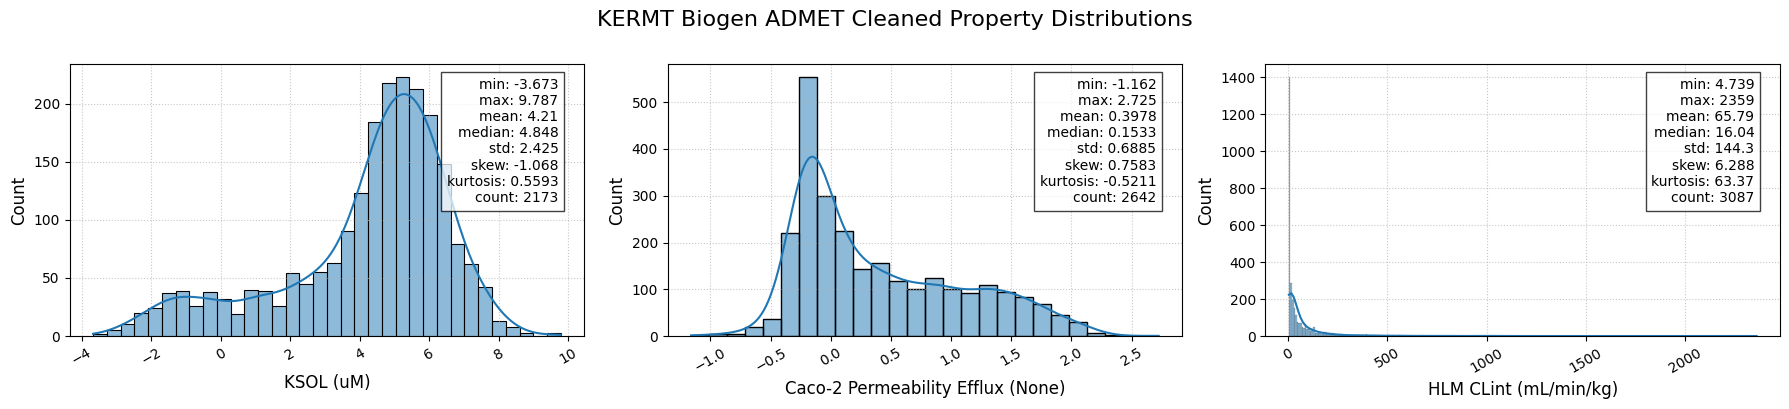

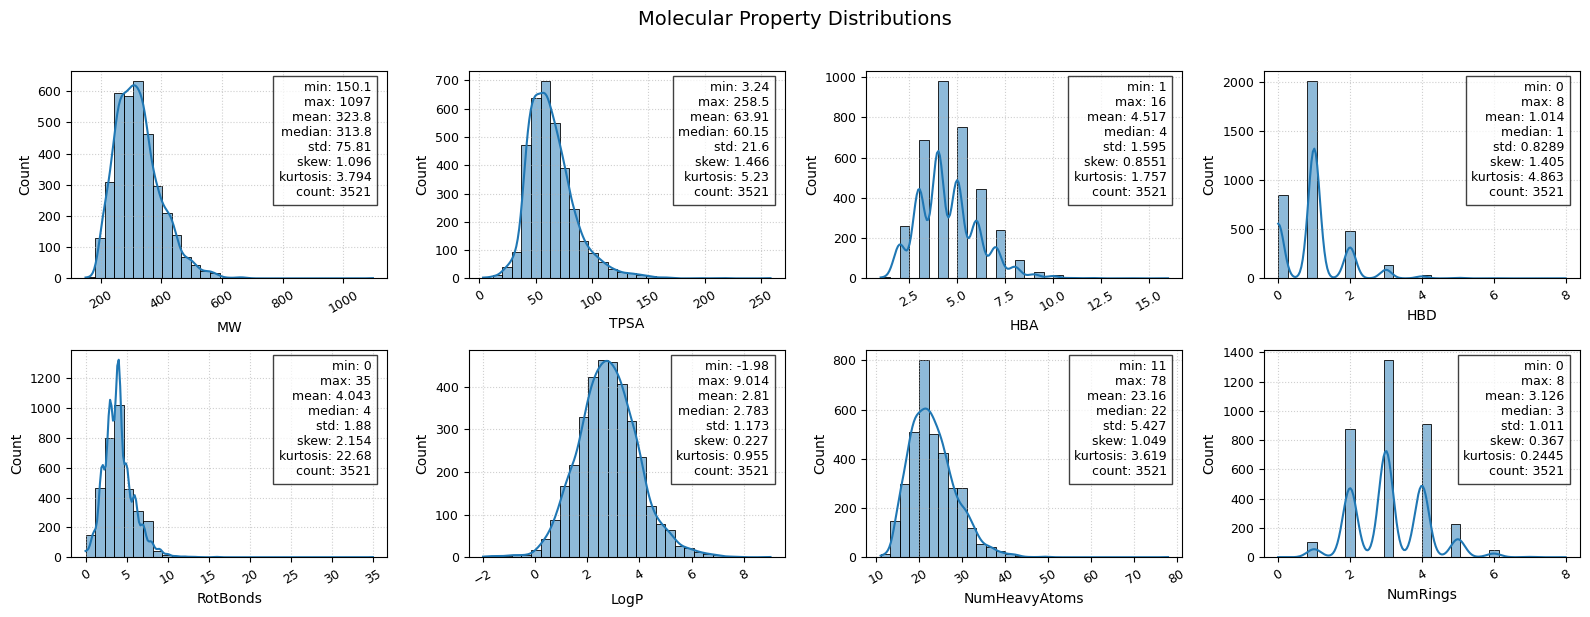

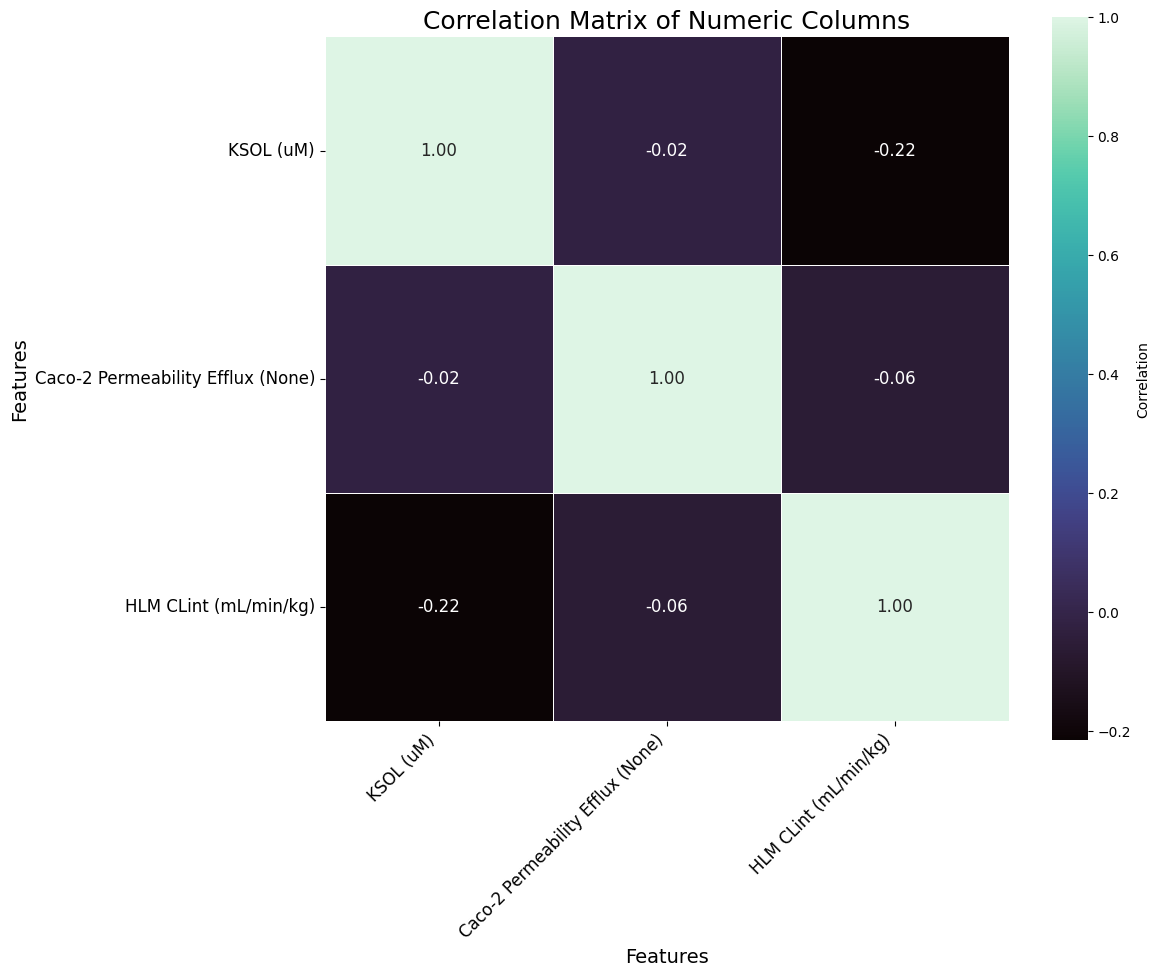

In [26]:
df = df_kermt_biogen_admet_cleaned.copy()
output_dir = data_path.parents[1] / "figures"
fname = "kermt_biogen_admet_cleaned"

df_props = compute_molecular_properties(df["SMILES"])
output_dir.mkdir(parents=True, exist_ok=True)

fig, ax = plot_numeric_distributions(
    df,
    n_cols=3,
    title="KERMT Biogen ADMET Cleaned Property Distributions",
    save_path=output_dir / f"{fname}_numeric_distributions.png",
)
fig, ax = plot_property_distributions(
    df_props,
    save_path=output_dir / f"{fname}_molecular_property_distributions.png",
)
fig, ax = plot_correlation_matrix(
    df,
    save_path=output_dir / f"{fname}_numeric_correlation_matrix.png",
)


### PharmaBench

In [ ]:
files_pharmabench = [
    "KERMT/export_biogen_cluster_split/all_test_cluster_morgan.csv",
    "KERMT/export_biogen_cluster_split/all_train_fold_0_cluster_morgan.csv",
    "KERMT/export_biogen_cluster_split/all_val_fold_0_cluster_morgan.csv",
]

map_cols_pharmabench_to_expansionrx = [
    {
        "input_col": "SOLY_6.8",  # FIXME: This is not pH 7
        "output_col": "KSOL (uM)",
        "transform": transformations["ug/mL to uM"],
    },
    {
        "input_col": "MDR1-MDCK_ER",  # FIXME: MDCK not Caco-2
        "output_col": "Caco-2 Permeability Efflux (None)",
        "transform": transformations["None"],
    },
    {
        "input_col": "HLM_CLint", # log10(mL/min/g)
        "output_col": "HLM CLint (mL/min/kg)",
        "transform": transformations["10^(x)"],
    },
]

### Admetica

In [ ]:
# TODO: Implement loading and processing

### TDC

In [ ]:
# TODO: Implement loading and processing

### NCATS

In [ ]:
# TODO: Implement loading and processing

### ChEMBL

In [ ]:
# TODO: Implement loading and processing

## Final

In [50]:
# Save all cleaned datasets as a single dataframe with column for dataset name
df_out = pd.DataFrame()
for name, df in cleaned_data.items():
    logger.info(f"Adding cleaned dataset '{name}' with shape {df.shape} to combined dataframe")
    df_temp = df.copy()
    df_temp["dataset"] = name
    df_out = pd.concat([df_out, df_temp], axis=0)
logger.info(f"Combined cleaned dataframe shape: {df_out.shape}")
df_out.reset_index(drop=True, inplace=True)
    
# limit datasets to physically reasonable ranges
df_props = compute_molecular_properties(df_out["SMILES"])
idx_drop = df_props["MW"] > 1000.0
idx_drop |= df_props["LogP"] < -5.0
idx_drop |= df_props["LogP"] > 10.0
idx_drop |= df_props["TPSA"] > 300.0
idx_drop |= df_props["HBA"] > 20
idx_drop |= df_props["HBD"] > 10
idx_drop |= df_props["RotBonds"] > 20
idx_drop |= df_props["NumRings"] > 10
# remove any idx_drop that are in the ExpansionRx teaser dataset
idx_teaser = df_out["dataset"] == "expansionrx_teaser"
idx_drop = idx_drop & ~idx_teaser
# drop entries
n_dropped = idx_drop.sum()
if n_dropped > 0:
    logger.warning(f"Dropping {n_dropped} entries from combined dataset due to unreasonable molecular properties")
    df_out = df_out.loc[~idx_drop].copy()
    
for name in cleaned_data.keys():
    df_subset = df_out[df_out["dataset"] == name]

    # check for repeated SMILES
    n_total = len(df_subset)
    n_unique = df_subset["SMILES"].nunique()
    n_duplicates = n_total - n_unique
    if n_duplicates > 0:
        logger.warning(f"Found {n_duplicates} duplicate SMILES in combined dataset for dataset '{name}'")
        # average (skip NaNs) over duplicates
        df_subset = df_subset.groupby("SMILES", as_index=False).mean()
        # update in main dataframe
        df_out = pd.concat(
            [df_out[df_out["dataset"] != name], df_subset],
            axis=0,
        )
        logger.info(f"Dataframe shape after averaging duplicates for dataset '{name}': {df_out.shape}")
        
        # look for rows where all ADMET values are NaN
        admet_cols = [col for col in df_subset.columns if col not in ["SMILES", "dataset"]]
        n_before = len(df_out)
        df_out = df_out.dropna(subset=admet_cols, how="all")
        n_after = len(df_out)
        n_dropped = n_before - n_after
        if n_dropped > 0:
            logger.warning(f"Dropped {n_dropped} rows with all NaN ADMET values for dataset '{name}' after averaging duplicates")
            df_out = df_out[df_out["dataset"] != name]
            df_out = pd.concat([df_out, df_subset], axis=0)

# look at overlap between datasets
dataset_names = list(cleaned_data.keys())
for i in range(len(dataset_names)):
    name_i = dataset_names[i]
    smiles_i = set(df_out[df_out["dataset"] == name_i]["SMILES"].tolist())
    for j in range(i + 1, len(dataset_names)):
        name_j = dataset_names[j]
        smiles_j = set(df_out[df_out["dataset"] == name_j]["SMILES"].tolist())
        overlap_smiles = smiles_i.intersection(smiles_j)
        n_overlap = len(overlap_smiles)
        if n_overlap > 0:
            logger.warning(f"Found {n_overlap} overlapping SMILES between datasets '{name_i}' and '{name_j}'")
            
# for any repeated SMILES across datasets, keep only the first occurrence, prioritizing
# ExpansionRx teaser > KERMT Public > KERMT Biogen > Pharmabench
df_out.sort_values(by="dataset", inplace=True)
df_out.drop_duplicates(subset=["SMILES"], keep="first", inplace=True) 

# save final combined cleaned dataset
df_out.reset_index(drop=True, inplace=True)
output_path = base_data_dir.parent / "cleaned_combined_datasets.csv"
df_out.to_csv(output_path, index=False)

2025-10-26 18:02:48,807 - __main__ - INFO - Adding cleaned dataset 'expansionrx_teaser' with shape (532, 11) to combined dataframe
2025-10-26 18:02:48,808 - __main__ - INFO - Adding cleaned dataset 'kermt_public' with shape (89043, 7) to combined dataframe
2025-10-26 18:02:48,812 - __main__ - INFO - Adding cleaned dataset 'kermt_biogen' with shape (3521, 4) to combined dataframe
2025-10-26 18:02:48,816 - __main__ - INFO - Combined cleaned dataframe shape: (93096, 12)
2025-10-26 18:03:22,541 - __main__ - WARNING - Dropping 120 entries from combined dataset due to unreasonable molecular properties
2025-10-26 18:03:22,593 - __main__ - WARNING - Found 2 overlapping SMILES between datasets 'expansionrx_teaser' and 'kermt_public'
2025-10-26 18:03:22,611 - __main__ - WARNING - Found 133 overlapping SMILES between datasets 'kermt_public' and 'kermt_biogen'


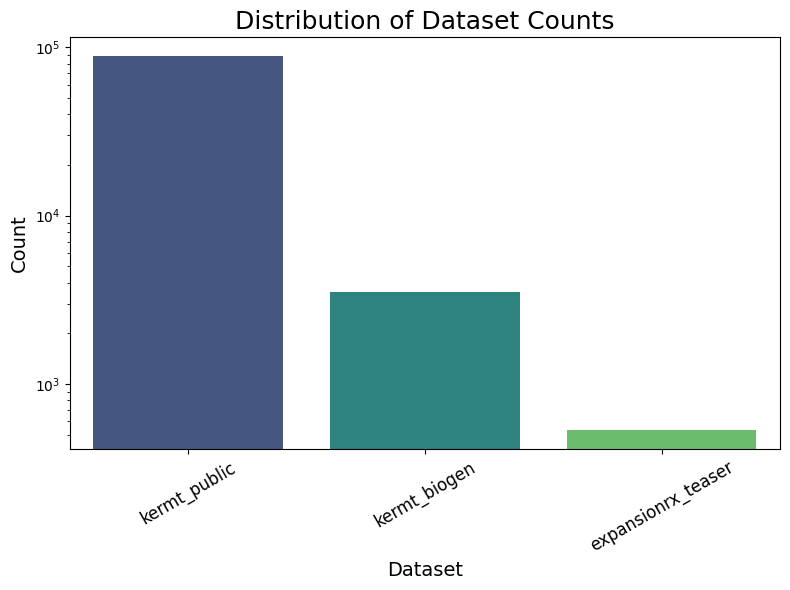

In [51]:
# plot the distribution of dataset counts
dataset_counts = df_out["dataset"].value_counts()
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(
    x=dataset_counts.index,
    y=dataset_counts.values,
    ax=ax,
    palette="viridis",
    hue=dataset_counts.index,
    dodge=False,
)
ax.set_xlabel("Dataset", fontsize=14)
ax.set_ylabel("Count", fontsize=14)
ax.set_title("Distribution of Dataset Counts", fontsize=18)
ax.tick_params(axis="x", labelrotation=30, labelsize=12)
ax.set_yscale("log")
fig.tight_layout()

2025-10-26 18:03:44,641 - __main__ - INFO - Plotting distribution for target column 'LogD (None)'
2025-10-26 18:03:44,907 - __main__ - INFO - Plotting distribution for target column 'KSOL (uM)'
2025-10-26 18:03:45,312 - __main__ - INFO - Plotting distribution for target column 'HLM CLint (mL/min/kg)'
2025-10-26 18:03:45,568 - __main__ - INFO - Plotting distribution for target column 'MLM CLint (mL/min/kg)'
2025-10-26 18:03:45,805 - __main__ - INFO - Plotting distribution for target column 'Caco-2 Permeability Papp A>B (10^-6 cm/s)'
2025-10-26 18:03:46,072 - __main__ - INFO - Plotting distribution for target column 'Caco-2 Permeability Efflux (None)'
2025-10-26 18:03:46,335 - __main__ - INFO - Plotting distribution for target column 'MPPB (% unbound)'
2025-10-26 18:03:46,565 - __main__ - INFO - Plotting distribution for target column 'MBPB (% unbound)'
2025-10-26 18:03:46,802 - __main__ - INFO - Plotting distribution for target column 'MGMB (% unbound)'
/tmp/ipykernel_82789/3067461605.p

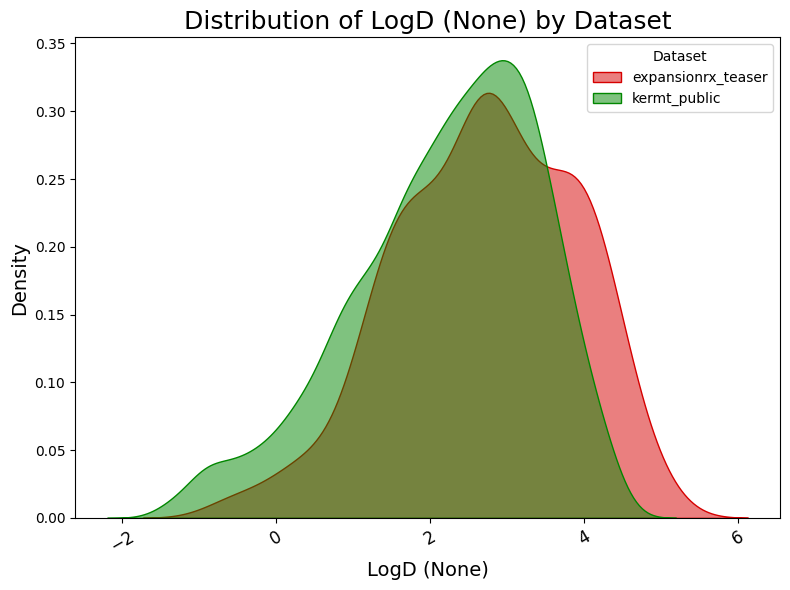

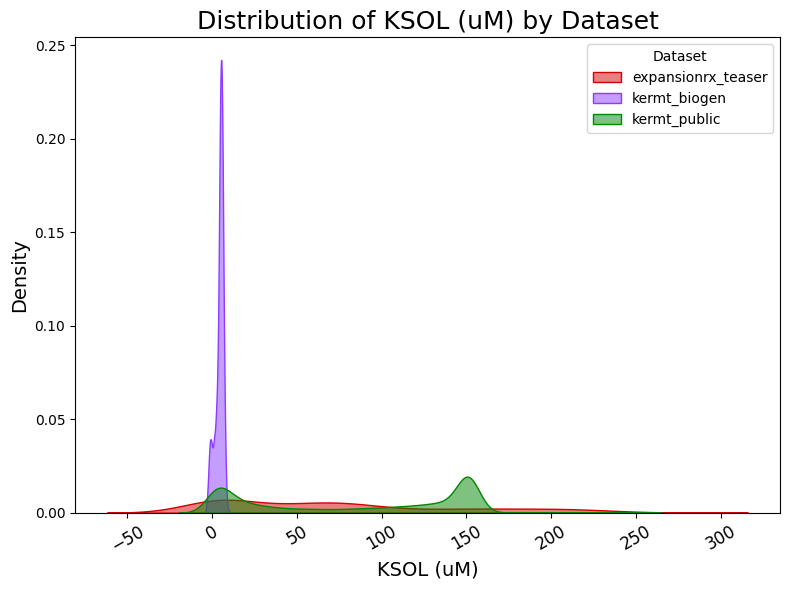

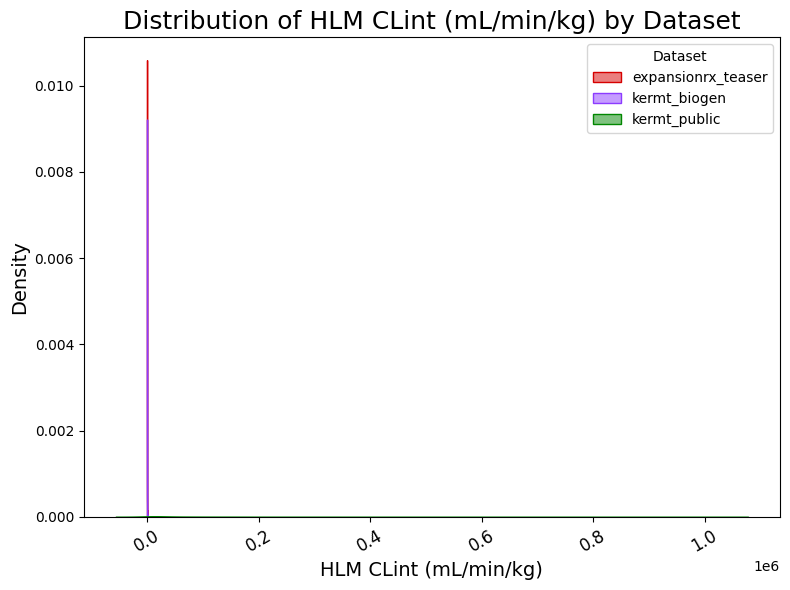

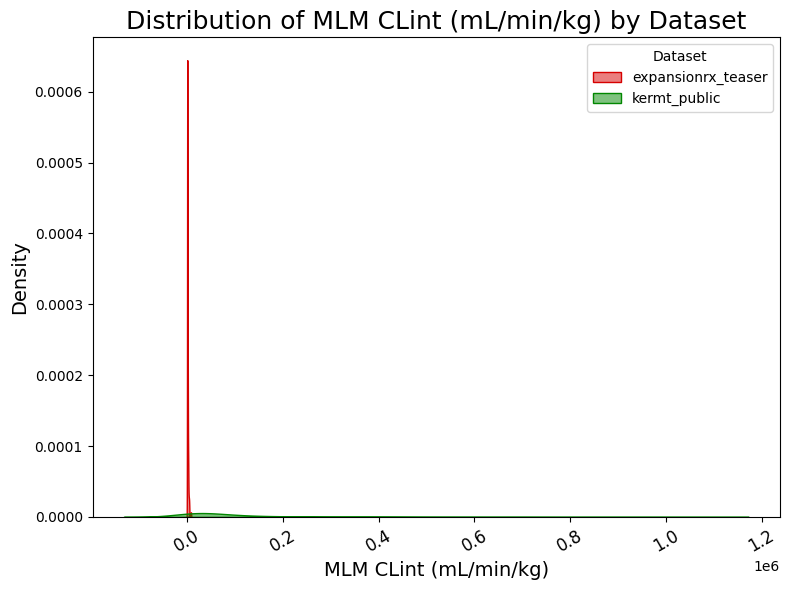

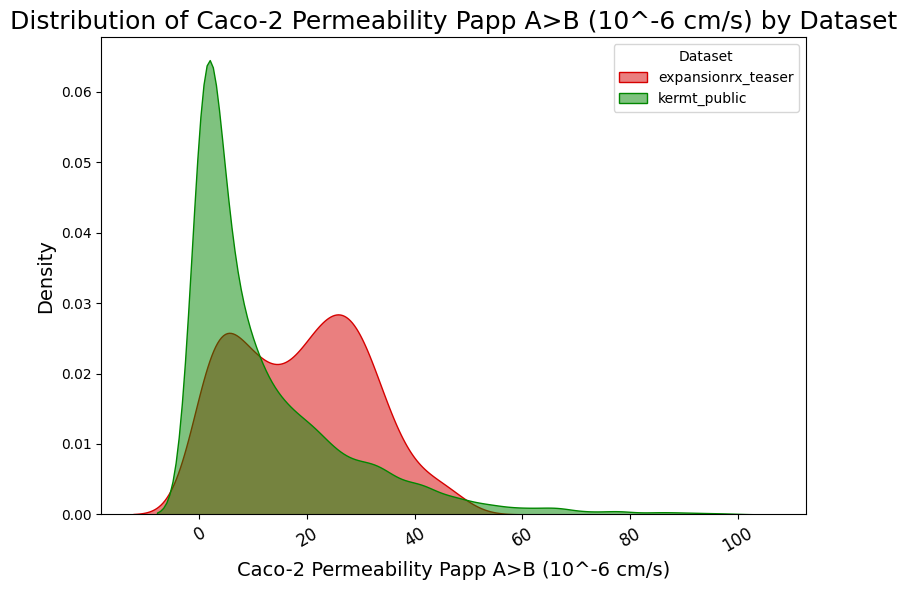

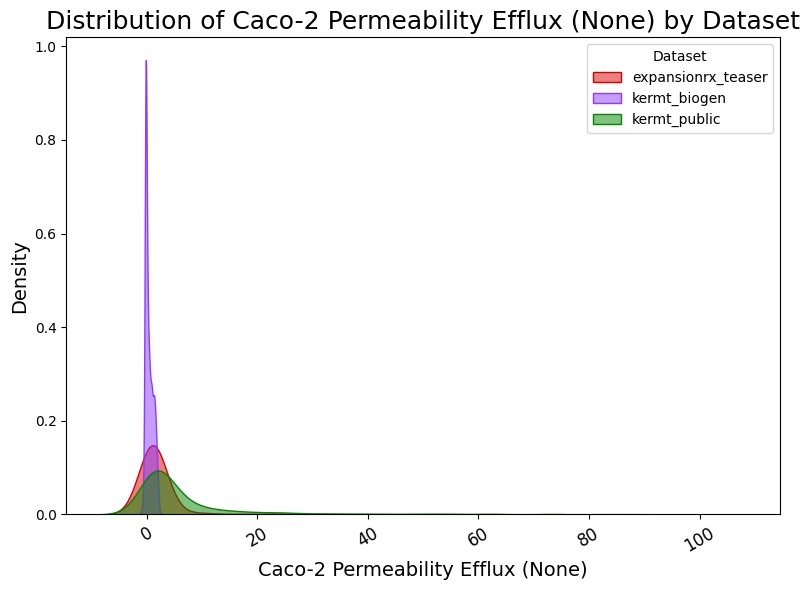

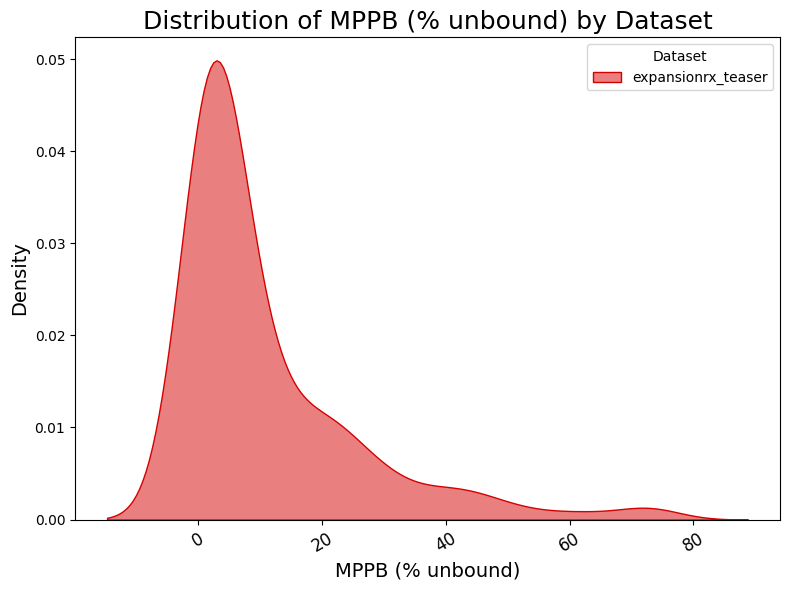

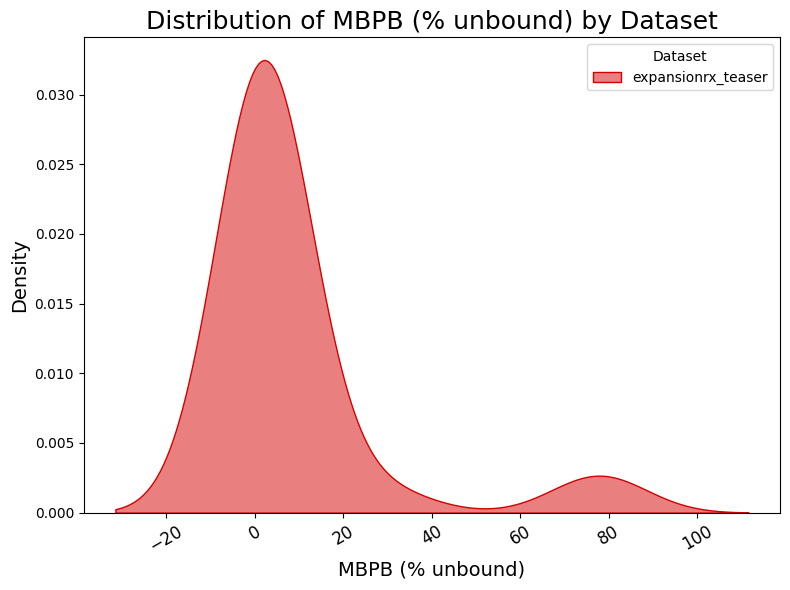

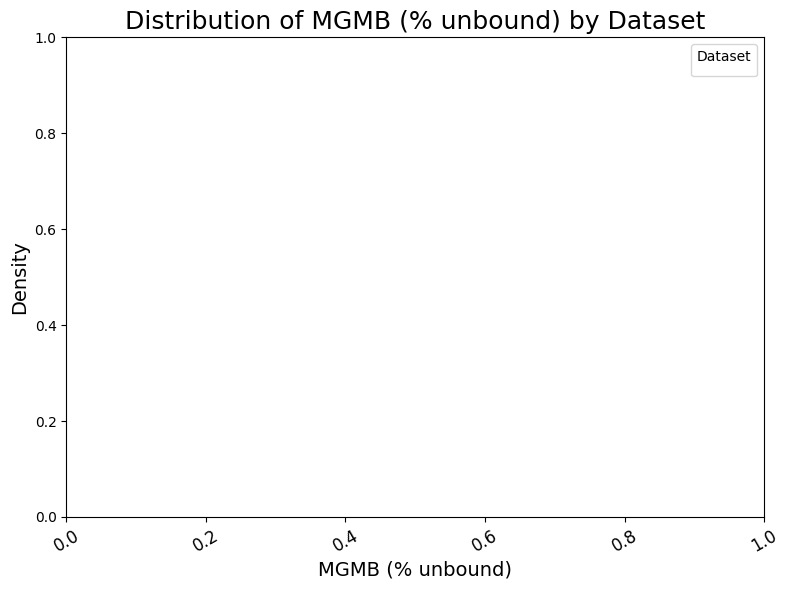

In [52]:
# plot the distribution of targets colored by dataset
target_cols = [col for col in df_out.columns if col != "SMILES" and col != "dataset"]

colormap = cc.glasbey  # categorical colormap
dataset_to_color = {name: colormap[i] for i, name in enumerate(df_out["dataset"].unique())}

for target_col in target_cols:
    if not pd.api.types.is_numeric_dtype(df_out[target_col]):
        continue
    fig, ax = plt.subplots(figsize=(8, 6))
    logger.info(f"Plotting distribution for target column '{target_col}'")
    for dataset_name, group in df_out.groupby("dataset"):
        sns.kdeplot(
            group[target_col].dropna(),
            ax=ax,
            label=dataset_name,
            fill=True,
            alpha=0.5,
            color=dataset_to_color[dataset_name],
        )
    ax.set_xlabel(target_col, fontsize=14)
    ax.set_ylabel("Density", fontsize=14)
    ax.set_title(f"Distribution of {target_col} by Dataset", fontsize=18)
    ax.tick_params(axis="x", labelrotation=30, labelsize=12)
    ax.legend(title="Dataset")
    fig.tight_layout()
    
    fig.savefig(
        output_dir / f"combined_{target_col.replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_to_')}_distribution.png",
        dpi=300,
    )



2025-10-26 17:53:33,159 - __main__ - INFO - Plotting distribution for molecular property 'MW'
2025-10-26 17:53:33,761 - __main__ - INFO - Plotting distribution for molecular property 'TPSA'
2025-10-26 17:53:34,463 - __main__ - INFO - Plotting distribution for molecular property 'HBA'
2025-10-26 17:53:35,047 - __main__ - INFO - Plotting distribution for molecular property 'HBD'
2025-10-26 17:53:35,643 - __main__ - INFO - Plotting distribution for molecular property 'RotBonds'
2025-10-26 17:53:36,238 - __main__ - INFO - Plotting distribution for molecular property 'LogP'
2025-10-26 17:53:36,820 - __main__ - INFO - Plotting distribution for molecular property 'NumHeavyAtoms'
2025-10-26 17:53:37,405 - __main__ - INFO - Plotting distribution for molecular property 'NumRings'


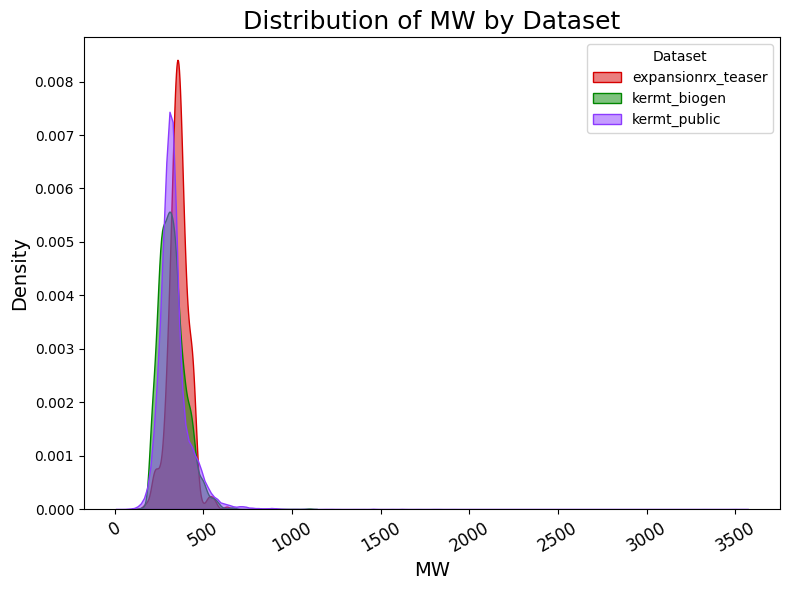

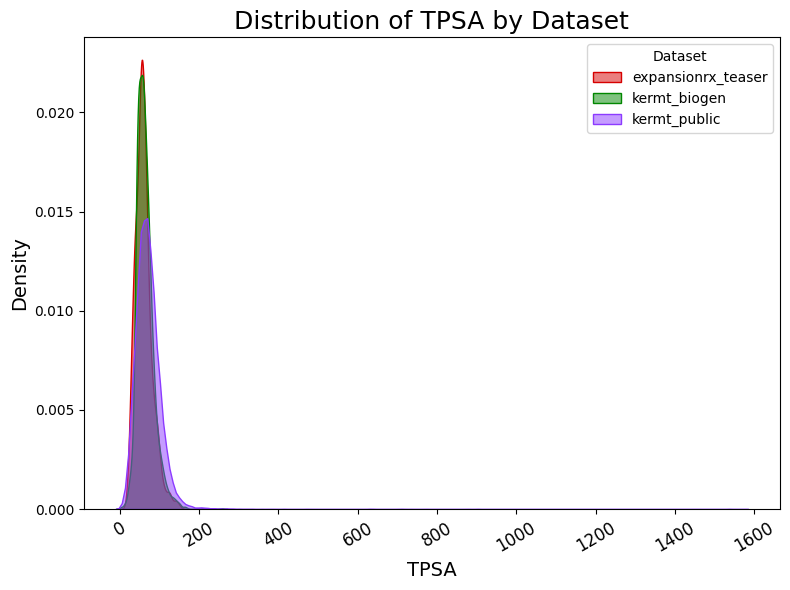

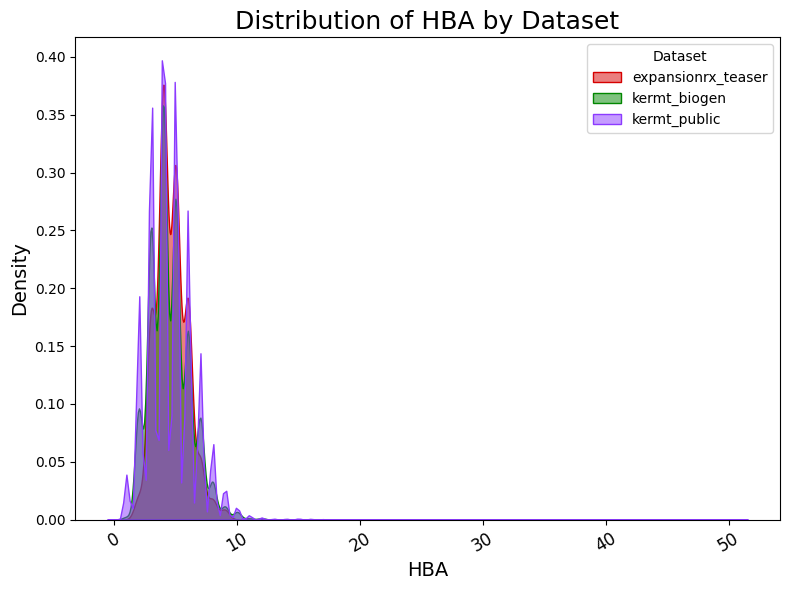

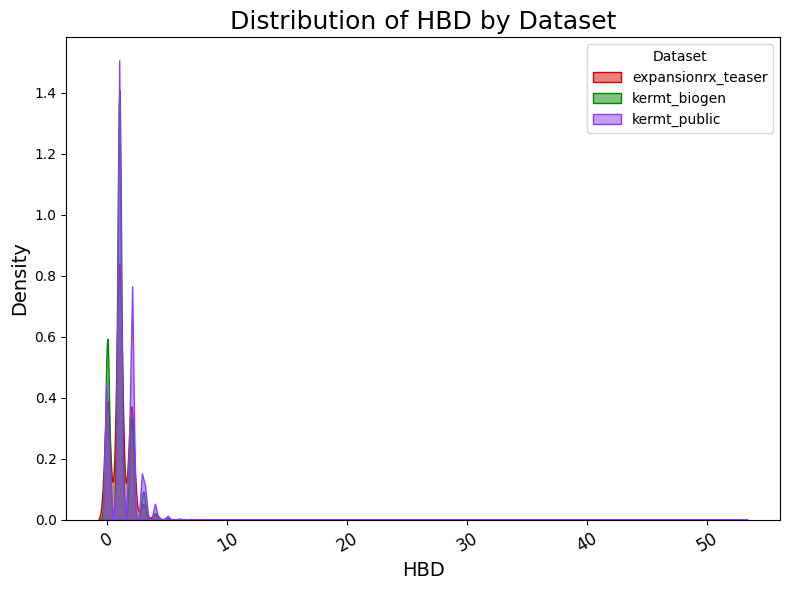

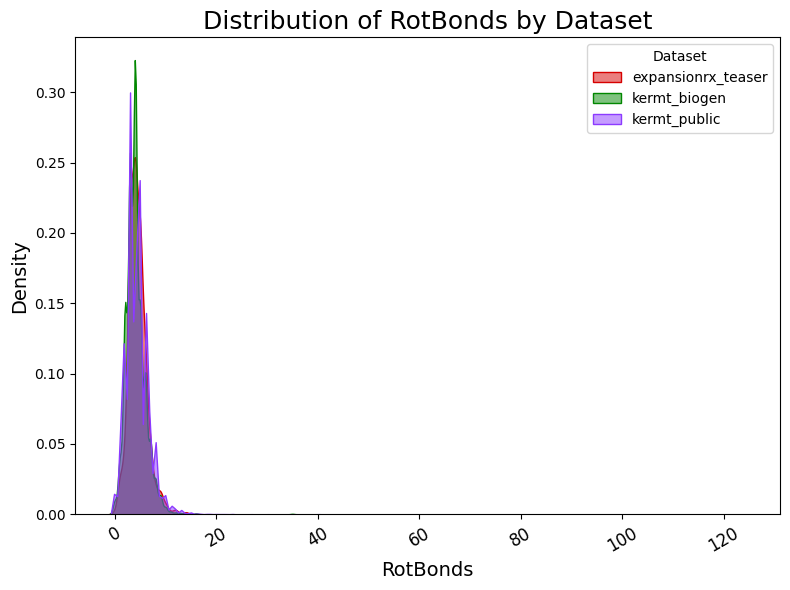

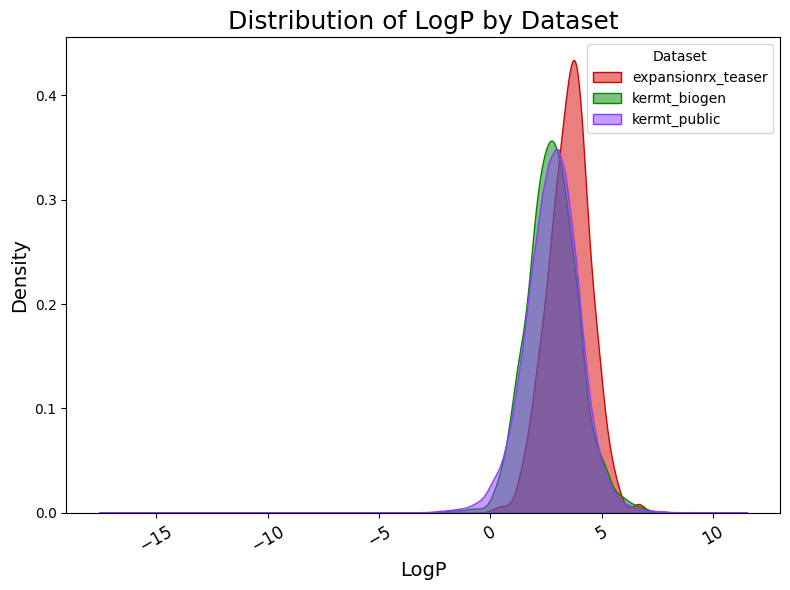

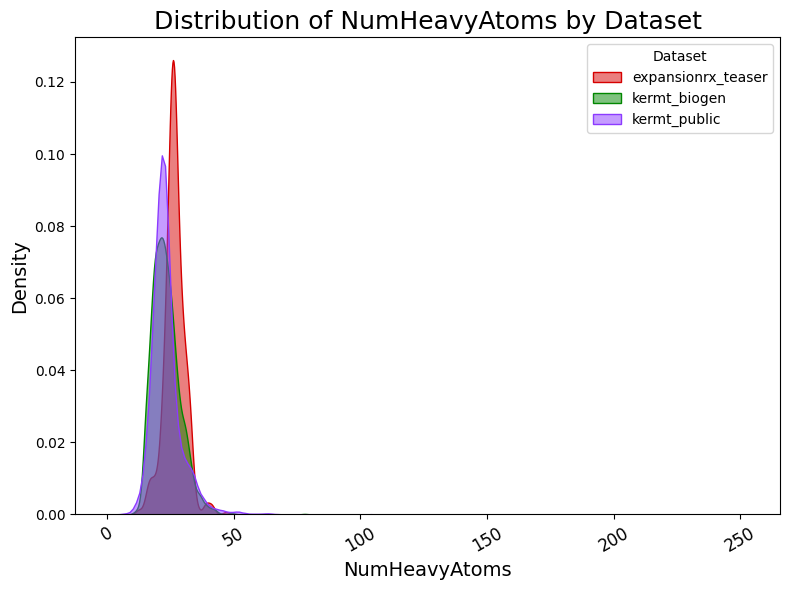

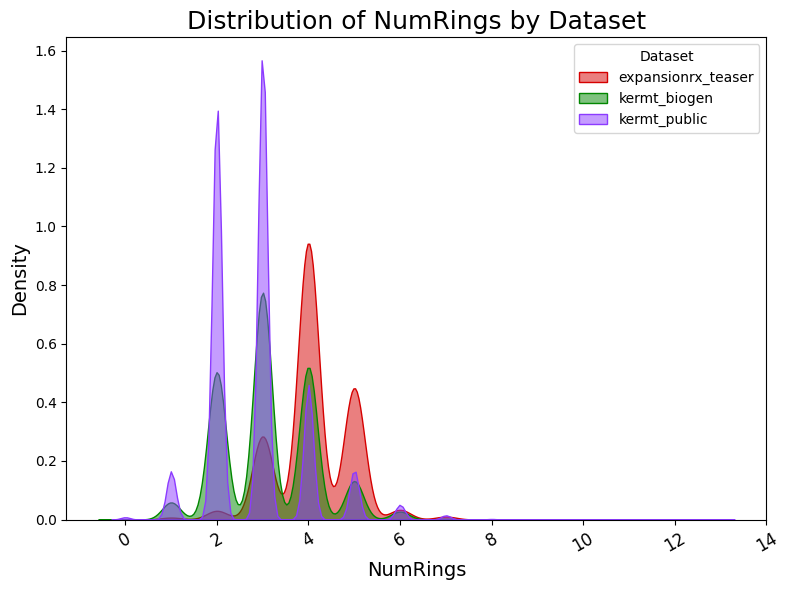

In [45]:
# plot distribution of molecular properties colored by dataset
df_props = compute_molecular_properties(df_out["SMILES"])
df_props["dataset"] = df_out["dataset"]
for prop_col in df_props.columns:
    if prop_col == "SMILES" or prop_col == "dataset":
        continue
    fig, ax = plt.subplots(figsize=(8, 6))
    logger.info(f"Plotting distribution for molecular property '{prop_col}'")
    for dataset_name, group in df_props.groupby("dataset"):
        sns.kdeplot(
            group[prop_col].dropna(),
            ax=ax,
            label=dataset_name,
            fill=True,
            alpha=0.5,
            color=dataset_to_color[dataset_name],
        )
    ax.set_xlabel(prop_col, fontsize=14)
    ax.set_ylabel("Density", fontsize=14)
    ax.set_title(f"Distribution of {prop_col} by Dataset", fontsize=18)
    ax.tick_params(axis="x", labelrotation=30, labelsize=12)
    ax.legend(title="Dataset")
    fig.tight_layout()
    
    fig.savefig(
        output_dir / f"combined_{prop_col.replace(' ', '_').replace('(', '').replace(')', '')}_distribution.png",
        bbox_inches="tight",
        dpi=300,
    )

In [ ]:
# TODO: look at SMILES overlap between datasets